# Results representation of SM

## 

In [2]:
import matplotlib.pyplot as plt  
import numpy as np
import os
import sys
import pandas as pd
import geopandas as gpd
import yaml

In [3]:
def process_key(key):
    # Convert string key to a tuple
    return safe_tuple_parser(key)

def process_value(value):
    # Convert string value to float
    return float(value)

def safe_tuple_parser(key):
    """
    Safely parses string representations of nested tuples into actual Python tuples.
    Example: "(2024, (1, 7, 0), (1, 8), 2024)" -> (2024, (1, 7, 0), (1, 8), 2024)
    """
    import ast  # Abstract Syntax Tree module for safe literal evaluation

    # Remove outer quotes if present and use `ast.literal_eval`
    try:
        return ast.literal_eval(key)
    except (SyntaxError, ValueError) as e:
        raise ValueError(f"Failed to parse key: {key}") from e

def read_data(case_study_name, input_folder_name, variables_to_read, run_id):
    current_path = os.getcwd()
    print("Current path:", current_path)
    file_results = os.path.normpath(current_path + "/results")
    print("File results:", os.path.normpath(file_results))
    file_path = os.path.join(current_path, "/results")
    print(file_path)
    # Normalize the path
    normalized_path = os.path.normpath(file_path)
    print("Normalized path:", normalized_path)

    # Reading input data from the folder
    folder_input = os.path.normpath(current_path + "/input_data/" + input_folder_name)
    input_data = {}
    for file_name in os.listdir(folder_input):
        if file_name.endswith(".yaml"):
            key_name = os.path.splitext(file_name)[0]  # Extract the key name from the file name
            if key_name != "SpatialFlexibilityEdges":  # Avoid overwriting existing keys
                with open(os.path.join(folder_input, file_name)) as file:
                    input_data[key_name] = yaml.safe_load(file)

    output_data = {}
    for variable in variables_to_read:
        file_name = os.path.normpath(file_results + "/" + input_folder + "/" + case_study_name + "_" + run_id + f"_{variable}_dict.yaml")
        with open(file_name) as file:
            data_dict = yaml.safe_load(file)
        output_data[variable] = {process_key(key): process_value(value) for key, value in data_dict.items()}
        print(f"Loaded {file_name} into output_data under variable '{variable}'")

    return input_data, output_data


In [4]:
case_study_name = "case_20251017_105556"
run_id = "cs_2025-10-17_11-56-16"  # FULLY CORRECTED + NUTS-filtered @ sm_nuts3_complete creation (DE, DK, AT, SE, NO, IT)
input_folder = case_study_name
variables_to_read = ["f", "h", "h_plus", "h_exist", "h_minus", "s", "q_fuel_infr_plus", "soc", "travel_time"]
# variables_to_read = ["f", "h", "h_plus", "h_exist", "h_minus", "s", "q_fuel_infr_plus", "soc"]

input_data, output_data = read_data(case_study_name, input_folder, variables_to_read, run_id)

Current path: c:\Users\simuser\Documents\AntoniaGolab\Scand_Med_analysis\iDesignRES_transcompmodel\examples\moving_loads_SM
File results: c:\Users\simuser\Documents\AntoniaGolab\Scand_Med_analysis\iDesignRES_transcompmodel\examples\moving_loads_SM\results
c:/results
Normalized path: c:\results
Loaded c:\Users\simuser\Documents\AntoniaGolab\Scand_Med_analysis\iDesignRES_transcompmodel\examples\moving_loads_SM\results\case_20251017_105556\case_20251017_105556_cs_2025-10-17_11-56-16_f_dict.yaml into output_data under variable 'f'
Loaded c:\Users\simuser\Documents\AntoniaGolab\Scand_Med_analysis\iDesignRES_transcompmodel\examples\moving_loads_SM\results\case_20251017_105556\case_20251017_105556_cs_2025-10-17_11-56-16_h_dict.yaml into output_data under variable 'h'
Loaded c:\Users\simuser\Documents\AntoniaGolab\Scand_Med_analysis\iDesignRES_transcompmodel\examples\moving_loads_SM\results\case_20251017_105556\case_20251017_105556_cs_2025-10-17_11-56-16_h_plus_dict.yaml into output_data under

In [5]:
y_init = input_data["Model"]["y_init"]
Y = input_data["Model"]["Y"]
pre_y = input_data["Model"]["pre_y"]
Y_end = y_init + Y 
G = pre_y + Y 
g_init = y_init - pre_y
print(y_init, Y, pre_y, Y_end, G, g_init)


2020 21 10 2041 31 2010


### Checking demand coverage

In [6]:
total_f_res = 0
for key, value in output_data["f"].items():
    if key[0] == 2024:
        total_f_res += value
print(total_f_res)
total_F = 0
for dictionary in input_data["Odpair"]:
    total_F += dictionary["F"][0]
print(total_F/1000)

if round(total_f_res, 2) == round(total_F/1000, 2):
    print("Results match!")

48647.43000100005
48647.43
Results match!


### Checking vehicle sizing

2020 2041


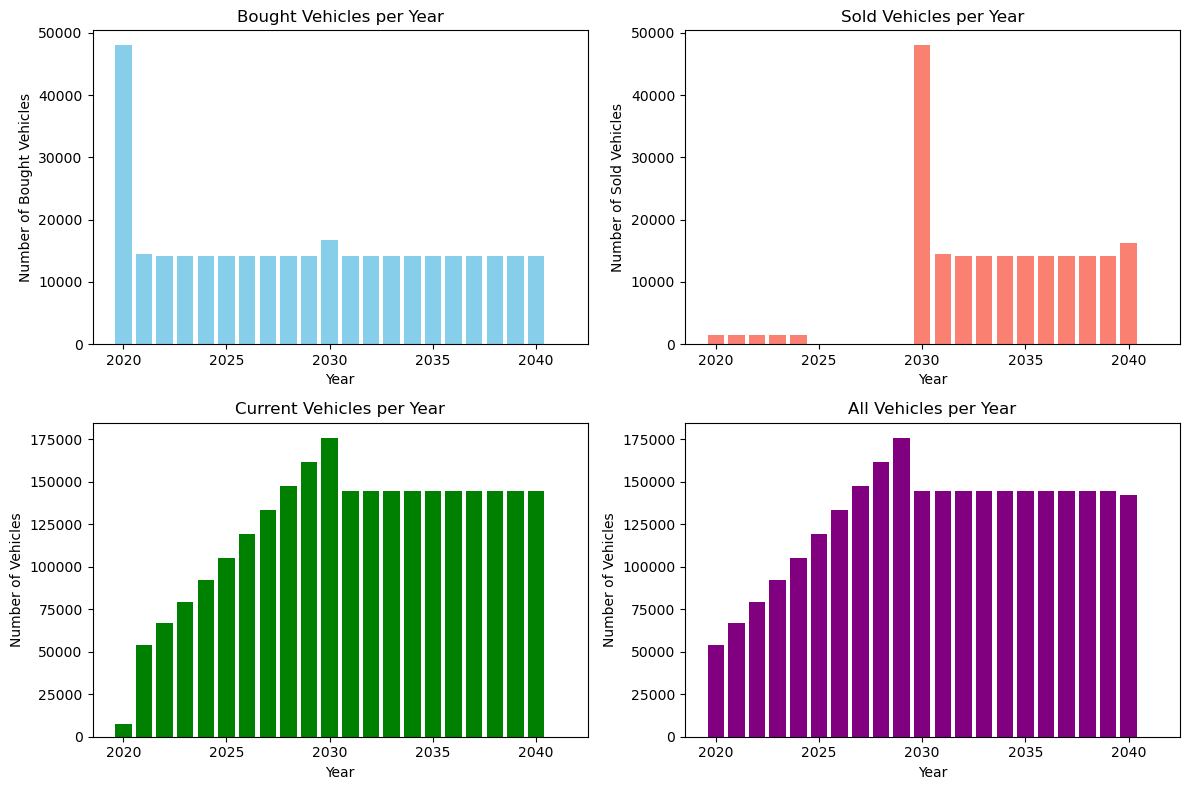

In [7]:
bought_vehicles = {}
exiting_vehicles = {}
h_now = {}
h_all = {}
odpair_list = input_data["Odpair"]
odpair_list = {d["id"]: d for d in odpair_list}
techvehicle_list = input_data["TechVehicle"]
techvehicle_list = {d["id"]: d for d in techvehicle_list}
h = output_data["h"]
h_plus = output_data["h_plus"]
h_exist = output_data["h_exist"]
h_minus = output_data["h_minus"]
print(y_init, Y_end)
for y in range(y_init, Y_end + 1):
    total_veh_number = sum(h_plus[(y, r, tv_id, g)] for g in range(g_init, y + 1) for r in odpair_list.keys() for tv_id in techvehicle_list.keys() if (y, r, tv_id, g) in h_plus.keys())
    bought_vehicles[y] = total_veh_number
    total_veh_number = sum(h_minus[(y, r, tv_id, g)] for g in range(g_init, y + 1) for r in odpair_list.keys() for tv_id in techvehicle_list.keys() if (y, r, tv_id, g) in h_minus.keys())
    exiting_vehicles[y] = total_veh_number
    total_veh_number = sum(h_exist[(y, r, tv_id, g)] for g in range(g_init, y + 1) for r in odpair_list.keys() for tv_id in techvehicle_list.keys() if (y, r, tv_id, g) in h_exist.keys())
    h_now[y] = total_veh_number
    total_veh_number = sum(h[(y, r, tv_id, g)] for g in range(g_init, y + 1) for r in odpair_list.keys() for tv_id in techvehicle_list.keys() if (y, r, tv_id, g) in h.keys())
    h_all[y] = total_veh_number

fig, axs = plt.subplots(2, 2, figsize=(12, 8))

years = range(y_init, Y_end + 1)

# Bought vehicles
bought_values = [bought_vehicles[year] for year in years]
axs[0, 0].bar(years, bought_values, color='skyblue')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Number of Bought Vehicles')
axs[0, 0].set_title('Bought Vehicles per Year')

# Sold vehicles
sold_values = [exiting_vehicles[year] for year in years]
axs[0, 1].bar(years, sold_values, color='salmon')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Number of Sold Vehicles')
axs[0, 1].set_title('Sold Vehicles per Year')

# Current vehicles
h_now_values = [h_now[year] for year in years]
axs[1, 0].bar(years, h_now_values, color='green')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Number of Vehicles')
axs[1, 0].set_title('Current Vehicles per Year')

# All vehicles
h_all_values = [h_all[year] for year in years]
axs[1, 1].bar(years, h_all_values, color='purple')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Number of Vehicles')
axs[1, 1].set_title('All Vehicles per Year')

plt.tight_layout()
plt.show()


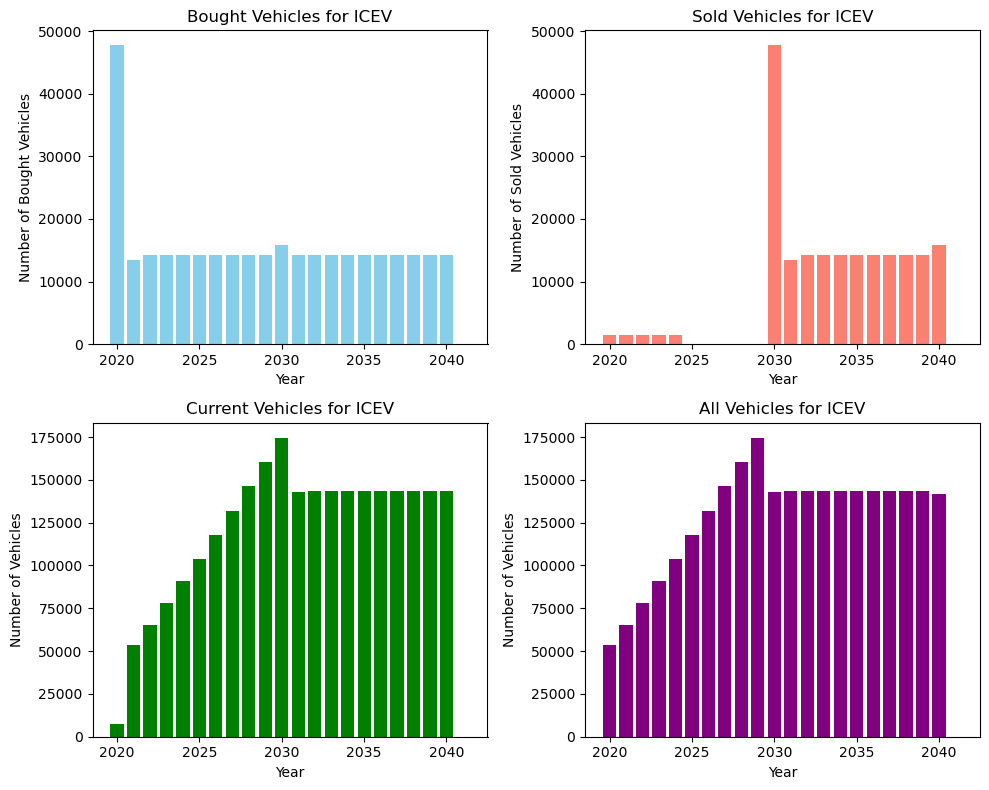

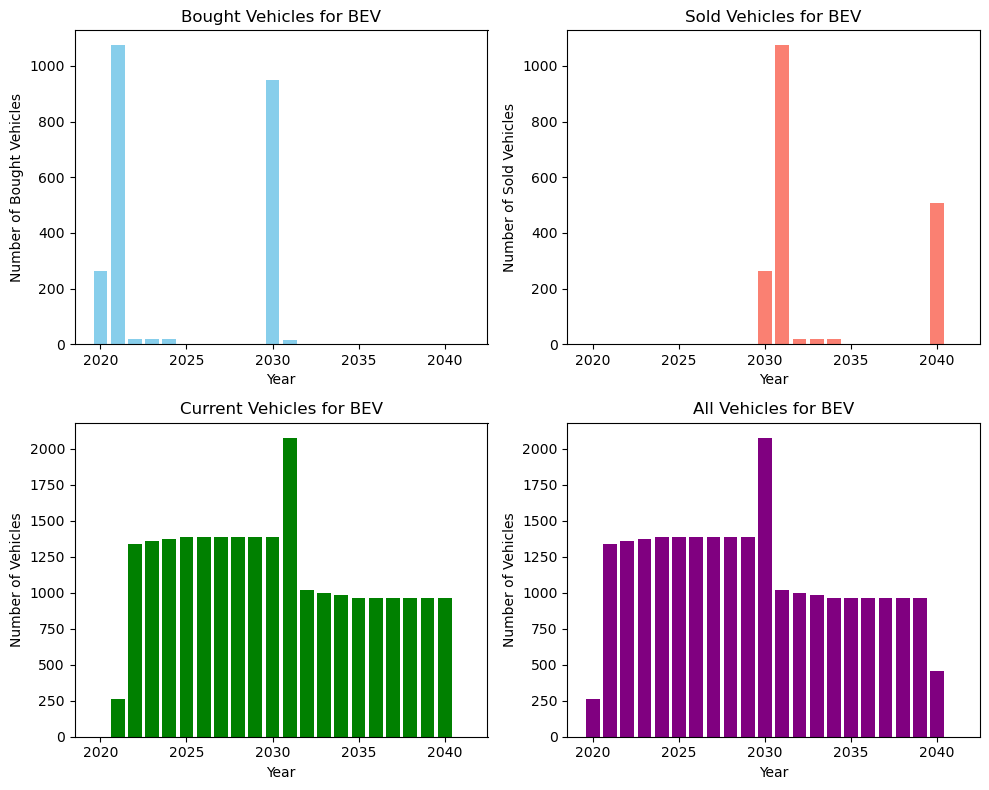

In [8]:
# Initialize dictionaries to store data by technology
bought_vehicles_by_tech = {tech_id: {year: 0 for year in years} for tech_id in techvehicle_list.keys()}
exiting_vehicles_by_tech = {tech_id: {year: 0 for year in years} for tech_id in techvehicle_list.keys()}
h_now_by_tech = {tech_id: {year: 0 for year in years} for tech_id in techvehicle_list.keys()}
h_all_by_tech = {tech_id: {year: 0 for year in years} for tech_id in techvehicle_list.keys()}

# Calculate values for each technology
for y in years:
    for tech_id in techvehicle_list.keys():
        bought_vehicles_by_tech[tech_id][y] = sum(
            h_plus[(y, r, tech_id, g)]
            for g in range(g_init, y + 1)
            for r in odpair_list.keys()
            if (y, r, tech_id, g) in h_plus.keys()
        )
        exiting_vehicles_by_tech[tech_id][y] = sum(
            h_minus[(y, r, tech_id, g)]
            for g in range(g_init, y + 1)
            for r in odpair_list.keys()
            if (y, r, tech_id, g) in h_minus.keys()
        )
        h_now_by_tech[tech_id][y] = sum(
            h_exist[(y, r, tech_id, g)]
            for g in range(g_init, y + 1)
            for r in odpair_list.keys()
            if (y, r, tech_id, g) in h_exist.keys()
        )
        h_all_by_tech[tech_id][y] = sum(
            h[(y, r, tech_id, g)]
            for g in range(g_init, y + 1)
            for r in odpair_list.keys()
            if (y, r, tech_id, g) in h.keys()
        )

# Plotting the data for each technology
for tech_id, tech_data in techvehicle_list.items():
    tech_name = tech_data["name"]

    # Bought vehicles
    bought_values = [bought_vehicles_by_tech[tech_id][year] for year in years]
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))

    # Bought vehicles
    bought_values = [bought_vehicles_by_tech[tech_id][year] for year in years]
    axs[0, 0].bar(years, bought_values, color='skyblue')
    axs[0, 0].set_xlabel('Year')
    axs[0, 0].set_ylabel('Number of Bought Vehicles')
    axs[0, 0].set_title(f'Bought Vehicles for {tech_name}')

    # Exiting vehicles
    sold_values = [exiting_vehicles_by_tech[tech_id][year] for year in years]
    axs[0, 1].bar(years, sold_values, color='salmon')
    axs[0, 1].set_xlabel('Year')
    axs[0, 1].set_ylabel('Number of Sold Vehicles')
    axs[0, 1].set_title(f'Sold Vehicles for {tech_name}')

    # Current vehicles
    h_now_values = [h_now_by_tech[tech_id][year] for year in years]
    axs[1, 0].bar(years, h_now_values, color='green')
    axs[1, 0].set_xlabel('Year')
    axs[1, 0].set_ylabel('Number of Vehicles')
    axs[1, 0].set_title(f'Current Vehicles for {tech_name}')

    # All vehicles
    h_all_values = [h_all_by_tech[tech_id][year] for year in years]
    axs[1, 1].bar(years, h_all_values, color='purple')
    axs[1, 1].set_xlabel('Year')
    axs[1, 1].set_ylabel('Number of Vehicles')
    axs[1, 1].set_title(f'All Vehicles for {tech_name}')

    plt.tight_layout()
    plt.show()


In [9]:
print(sum(output_data["s"].values()))
print(input_data["Product"])  # Example of accessing specific input data

9243465612.074373
[{'id': 0, 'name': 'freight'}]


In [10]:
# Convert lists to dictionaries once at the beginning
geographic_element_list = {d["id"]: d for d in input_data["GeographicElement"]}
path_list_all = {d["id"]: d for d in input_data["Path"]}

# FILTER: Only keep paths >= 360km (test case filter)
MIN_PATH_LENGTH_KM = 360.0
path_list = {path_id: path_data for path_id, path_data in path_list_all.items() 
             if path_data.get("length", 0) >= MIN_PATH_LENGTH_KM}

print(f"Path filtering:")
print(f"  Total paths in input: {len(path_list_all)}")
print(f"  Paths >= {MIN_PATH_LENGTH_KM} km: {len(path_list)}")
print(f"  Filtered out: {len(path_list_all) - len(path_list)}")
if len(path_list) > 0:
    lengths = [p["length"] for p in path_list.values()]
    print(f"  Min path length: {min(lengths):.1f} km")
    print(f"  Max path length: {max(lengths):.1f} km")
    print(f"  Avg path length: {sum(lengths)/len(lengths):.1f} km")
print()

fueling_infr_types_list = {d["id"]: d for d in input_data["FuelingInfrTypes"]}
fuel_list = {d["name"]: d for d in input_data["Fuel"]}
technology_list = {d["id"]: d for d in input_data["Technology"]}

# Pre-compute fuel mapping for each infrastructure type
fuel_to_infr_types = {}
for l_id, l_data in fueling_infr_types_list.items():
    fuel = l_data["fuel"]
    if fuel not in fuel_to_infr_types:
        fuel_to_infr_types[fuel] = []
    fuel_to_infr_types[fuel].append((l_id, fuel_list[fuel]["id"]))

print("Fuel to infrastructure mapping:")
for fuel, infr_types in fuel_to_infr_types.items():
    print(f"  {fuel}: {infr_types}")

total_kWh = 0
required_fuel = 0

# Main loop
for odpair, odpair_data in odpair_list.items():
    path_id = odpair_data["path_id"]
    
    # Skip if path was filtered out
    if path_id not in path_list:
        continue
        
    path_data = path_list[path_id]
    length = path_data["length"]
    sequence = path_data["sequence"]

    for tv, tv_data in techvehicle_list.items():
        spec_cons = tv_data["spec_cons"]
        W = tv_data["W"]
        tech = tv_data["technology"]
        fuel = technology_list[tech]["fuel"]

        # Get relevant infrastructure types for this fuel (pre-computed)
        relevant_infr = fuel_to_infr_types.get(fuel, [])

        for y in range(y_init, Y_end + 1):
            for g in range(g_init, y + 1):
                key_f = (y, (0, odpair, path_id), (1, tv), g)

                # Check if key exists before accessing
                if key_f in output_data["f"]:
                    total_Tkm = output_data["f"][key_f] * length
                    # Use correct indexing: spec_cons and W are indexed from g_init
                    required_fuel += total_Tkm * spec_cons[g - g_init] / W[g - g_init]

                    # Only loop through relevant infrastructure types
                    for e in sequence:
                        for l_id, fuel_id in relevant_infr:
                            # FIXED: Use correct fuel-infrastructure pair (fuel_id, l_id) not (l_id, fuel_id)
                            key_s = (y, (0, odpair, path_id, e), tv, (fuel_id, l_id), g)
                            if key_s in output_data["s"]:
                                total_kWh += output_data["s"][key_s]

print("Total energy demand (kWh):", required_fuel, total_kWh)
print(f"Match: {abs(required_fuel - total_kWh) < 1.0}")

Path filtering:
  Total paths in input: 2928
  Paths >= 360.0 km: 2928
  Filtered out: 0
  Min path length: 360.9 km
  Max path length: 3266.7 km
  Avg path length: 1352.3 km

Fuel to infrastructure mapping:
  electricity: [(1, 0), (2, 0)]
  diesel: [(0, 1)]
Total energy demand (kWh): 9243000158.760433 9243465612.074791
Match: False


In [11]:
# Verifying Fueling Infrastructure Sizing

# Build mapping from fueling_type string to infrastructure type ID
fueling_type_to_id = {}
for l_id, l_data in fueling_infr_types_list.items():
    fueling_type_str = l_data["fueling_type"]
    fueling_type_to_id[fueling_type_str] = l_id

print("Fueling type to ID mapping:")
for ft, fid in fueling_type_to_id.items():
    print(f"  '{ft}' -> id={fid}")

# Get initial fueling infrastructure
# Key by (fuel_name, infr_type_id, allocation) for easy lookup
initial_fueling_infr = {}
for d in input_data["InitialFuelInfr"]:
    fuel_name = d["fuel"]
    fueling_type_str = d["type"]
    allocation = d["allocation"]
    
    # Map fueling_type string to infrastructure type ID
    infr_type_id = fueling_type_to_id.get(fueling_type_str)
    if infr_type_id is not None:
        key = (fuel_name, infr_type_id, allocation)
        initial_fueling_infr[key] = d

print(f"\nTotal initial infrastructure entries (after mapping): {len(initial_fueling_infr)}")

# Get investment period
investment_period = input_data["Model"]["investment_period"]
investment_years = list(range(y_init, Y_end + 1, investment_period))
print(f"Investment years: {investment_years}")

# Create fuel-infrastructure pairs (f_l pairs)
f_l_pairs = set()
fuel_name_to_id = {}
for l_id, l_data in fueling_infr_types_list.items():
    fuel_name = l_data["fuel"]
    fuel_id = fuel_list[fuel_name]["id"]
    fuel_name_to_id[fuel_name] = fuel_id
    f_l_pairs.add((fuel_id, l_id))

print(f"\nFuel infrastructure pairs (fuel_id, infr_id):")
for f_l in sorted(f_l_pairs):
    fuel_id, infr_id = f_l
    fuel_name = [k for k, v in fuel_list.items() if v["id"] == fuel_id][0]
    infr_data = fueling_infr_types_list[infr_id]
    gamma = infr_data.get("gamma", [1.0])[0] if isinstance(infr_data.get("gamma", 1.0), list) else infr_data.get("gamma", 1.0)
    by_route = infr_data.get("by_route", False)
    fueling_type = infr_data.get("fueling_type", "unknown")
    print(f"  {f_l}: {fuel_name} / {fueling_type}, gamma={gamma:.4f}, by_route={by_route}")

# Check initial infrastructure capacity by fuel type
for fuel_id in [0, 1]:
    fuel_name = [k for k, v in fuel_list.items() if v["id"] == fuel_id][0]
    # Find corresponding infrastructure type ID
    infr_id = None
    for lid, ldata in fueling_infr_types_list.items():
        if ldata["fuel"] == fuel_name:
            infr_id = lid
            break
    
    if infr_id is not None:
        fuel_initial = [(k, v) for k, v in initial_fueling_infr.items() if k[0] == fuel_name and k[1] == infr_id]
        total_cap = sum(v['installed_kW'] for k, v in fuel_initial)
        print(f"\n🔍 {fuel_name.upper()} (fuel_id={fuel_id}, infr_id={infr_id}):")
        print(f"  Initial infrastructure entries: {len(fuel_initial)}")
        print(f"  Total initial capacity: {total_cap:,.0f} kW")

# Check what q_fuel_infr_plus values we have
print(f"\nTotal q_fuel_infr_plus entries: {len(output_data['q_fuel_infr_plus'])}")
for fuel_id in [0, 1]:
    fuel_name = [k for k, v in fuel_list.items() if v["id"] == fuel_id][0]
    # Find corresponding infrastructure type ID
    infr_id = None
    for lid, ldata in fueling_infr_types_list.items():
        if ldata["fuel"] == fuel_name:
            infr_id = lid
            break
    
    if infr_id is not None:
        f_l = (fuel_id, infr_id)
        infr_q_entries = [(k, v) for k, v in output_data["q_fuel_infr_plus"].items() if k[1] == f_l]
        total_added = sum(v for k, v in infr_q_entries)
        print(f"  {fuel_name} ({f_l}): {len(infr_q_entries)} entries, {total_added:,.2f} kW added")

# Check energy consumption by fuel type
print(f"\nEnergy consumption (s variable):")
for fuel_id in [0, 1]:
    fuel_name = [k for k, v in fuel_list.items() if v["id"] == fuel_id][0]
    # Find corresponding infrastructure type ID
    infr_id = None
    for lid, ldata in fueling_infr_types_list.items():
        if ldata["fuel"] == fuel_name:
            infr_id = lid
            break
    
    if infr_id is not None:
        f_l = (fuel_id, infr_id)
        s_entries = [(k, v) for k, v in output_data["s"].items() if k[3] == f_l]
        total_consumption = sum(v for k, v in s_entries)
        print(f"  {fuel_name} ({f_l}): {total_consumption:,.2f} kWh")

# Verification results storage
verification_results = []
violations = []

# For each year, fuel-infrastructure pair, and geographic element
for y in range(y_init, Y_end + 1):
    for f_l in f_l_pairs:
        fuel_id, infr_type_id = f_l
        
        # Get gamma (load factor) for this infrastructure type
        infr_data = fueling_infr_types_list[infr_type_id]
        gamma = infr_data.get("gamma", 1.0)
        if isinstance(gamma, list):
            gamma_val = gamma[y - y_init] if (y - y_init) < len(gamma) else gamma[-1]
        else:
            gamma_val = gamma
        
        # Convert gamma to factor
        factor_gamma = 1 / (gamma_val * 8760) if gamma_val > 0 else 0
        
        for geo_id, geo_data in geographic_element_list.items():
            # Get fuel name
            fuel_name = [k for k, v in fuel_list.items() if v["id"] == fuel_id][0]
            
            # Get initial capacity using corrected mapping
            initial_key = (fuel_name, infr_type_id, geo_id)
            initial_capacity = 0
            if initial_key in initial_fueling_infr:
                initial_capacity = initial_fueling_infr[initial_key]["installed_kW"]
            
            # Sum q_fuel_infr_plus up to year y
            total_added_capacity = 0
            for y0 in investment_years:
                if y0 <= y:
                    key_q = (y0, f_l, geo_id)
                    if key_q in output_data["q_fuel_infr_plus"]:
                        total_added_capacity += output_data["q_fuel_infr_plus"][key_q]
            
            total_capacity = initial_capacity + total_added_capacity
            
            # Calculate RHS: energy demand
            total_energy_demand = 0
            for g in range(g_init, y + 1):
                for odpair_id, odpair_data in odpair_list.items():
                    path_id = odpair_data["path_id"]
                    path_data = path_list[path_id]
                    sequence = path_data["sequence"]
                    
                    if geo_id in sequence:
                        for tv_id, tv_data in techvehicle_list.items():
                            tech_id = tv_data["technology"]
                            tech_data = technology_list[tech_id]
                            vehicle_fuel_name = tech_data["fuel"]
                            vehicle_fuel_id = fuel_list[vehicle_fuel_name]["id"]
                            
                            if vehicle_fuel_id == fuel_id:
                                key_s = (y, (0, odpair_id, path_id, geo_id), tv_id, f_l, g)
                                if key_s in output_data["s"]:
                                    total_energy_demand += output_data["s"][key_s]
            
            required_capacity = factor_gamma * 1000 * total_energy_demand
            
            if total_capacity > 0 or required_capacity > 0:
                slack = total_capacity - required_capacity
                is_satisfied = slack >= -1e-6
                
                result = {
                    'year': y,
                    'fuel_id': fuel_id,
                    'fuel_name': fuel_name,
                    'infr_type_id': infr_type_id,
                    'geo_id': geo_id,
                    'initial_capacity': initial_capacity,
                    'added_capacity': total_added_capacity,
                    'total_capacity': total_capacity,
                    'required_capacity': required_capacity,
                    'slack': slack,
                    'satisfied': is_satisfied,
                    'gamma': gamma_val,
                    'factor_gamma': factor_gamma,
                    'has_initial': initial_key in initial_fueling_infr,
                    'energy_demand': total_energy_demand
                }
                
                verification_results.append(result)
                
                if not is_satisfied:
                    violations.append(result)

# Print summary
print(f"\n{'='*80}")
print(f"INFRASTRUCTURE SIZING VERIFICATION RESULTS")
print(f"{'='*80}")
print(f"Total checks performed: {len(verification_results)}")
print(f"Constraints satisfied: {len([r for r in verification_results if r['satisfied']])}")
print(f"Violations found: {len(violations)}")

if len(violations) > 0:
    print(f"\n⚠️  VIOLATIONS DETECTED:")
    print(f"{'Year':<6} {'Fuel':<12} {'Geo':<6} {'HasInit':<8} {'InitCap':<12} {'AddedCap':<12} {'TotalCap':<12} {'Required':<12} {'Slack':<12}")
    print("-" * 110)
    for v in violations[:20]:
        print(f"{v['year']:<6} {v['fuel_name']:<12} {v['geo_id']:<6} "
              f"{'Yes' if v['has_initial'] else 'No':<8} "
              f"{v['initial_capacity']:>11,.2f} {v['added_capacity']:>11,.2f} {v['total_capacity']:>11,.2f} {v['required_capacity']:>11,.2f} {v['slack']:>11,.2f}")
    if len(violations) > 20:
        print(f"... and {len(violations) - 20} more violations")
    
    # Analyze violations by fuel type
    print(f"\n📊 VIOLATION ANALYSIS BY FUEL TYPE:")
    for fuel_id in [0, 1]:
        fuel_name = [k for k, v in fuel_list.items() if v["id"] == fuel_id][0]
        fuel_violations = [v for v in violations if v['fuel_id'] == fuel_id]
        if len(fuel_violations) > 0:
            total_deficit = sum(abs(v['slack']) for v in fuel_violations if v['slack'] < 0)
            total_required = sum(v['required_capacity'] for v in fuel_violations)
            total_provided = sum(v['total_capacity'] for v in fuel_violations)
            print(f"\n  {fuel_name.upper()}:")
            print(f"    Violations: {len(fuel_violations)}")
            print(f"    Total capacity provided: {total_provided:,.2f} kW")
            print(f"    Total capacity required: {total_required:,.2f} kW")
            print(f"    Total deficit: {total_deficit:,.2f} kW")
            print(f"    Capacity utilization: {(total_required / total_provided * 100) if total_provided > 0 else float('inf'):.1f}%")
else:
    print("\n✅ All infrastructure sizing constraints are satisfied!")

# Overall statistics
if len(verification_results) > 0:
    print(f"\n{'='*80}")
    print(f"OVERALL STATISTICS:")
    print(f"{'='*80}")
    
    # Break down by fuel type
    for fuel_id in [0, 1]:
        fuel_name = [k for k, v in fuel_list.items() if v["id"] == fuel_id][0]
        fuel_results = [r for r in verification_results if r['fuel_id'] == fuel_id]
        if len(fuel_results) > 0:
            fuel_capacity = sum(r['total_capacity'] for r in fuel_results)
            fuel_required = sum(r['required_capacity'] for r in fuel_results)
            fuel_initial = sum(r['initial_capacity'] for r in fuel_results)
            fuel_added = sum(r['added_capacity'] for r in fuel_results)
            print(f"\n  {fuel_name.upper()}:")
            print(f"    Initial capacity:  {fuel_initial:>15,.2f} kW")
            print(f"    Added capacity:    {fuel_added:>15,.2f} kW")
            print(f"    Total capacity:    {fuel_capacity:>15,.2f} kW")
            print(f"    Required capacity: {fuel_required:>15,.2f} kW")
            print(f"    Slack:             {fuel_capacity - fuel_required:>15,.2f} kW")
            if fuel_required > 0:
                print(f"    Utilization:       {fuel_required / fuel_capacity * 100:>14.1f}%")

Fueling type to ID mapping:
  'slow_charging_station' -> id=1
  'fast_charging_station' -> id=2
  'conventional_fueling_station' -> id=0

Total initial infrastructure entries (after mapping): 75
Investment years: [2020, 2025, 2030, 2035, 2040]

Fuel infrastructure pairs (fuel_id, infr_id):
  (0, 1): electricity / slow_charging_station, gamma=0.3000, by_route=False
  (0, 2): electricity / fast_charging_station, gamma=0.3000, by_route=False
  (1, 0): diesel / conventional_fueling_station, gamma=0.3000, by_route=False

🔍 ELECTRICITY (fuel_id=0, infr_id=1):
  Initial infrastructure entries: 0
  Total initial capacity: 0 kW

🔍 DIESEL (fuel_id=1, infr_id=0):
  Initial infrastructure entries: 75
  Total initial capacity: 375,000 kW

Total q_fuel_infr_plus entries: 236
  electricity ((0, 1)): 79 entries, 72,807.15 kW added
  diesel ((1, 0)): 75 entries, 168,033,567.30 kW added

Energy consumption (s variable):
  electricity ((0, 1)): 1,290,693.15 kWh
  diesel ((1, 0)): 9,240,884,225.77 kWh

IN

Investment years: [2020, 2025, 2030, 2035, 2040]
Years with actual additions: [2020, 2025, 2030]


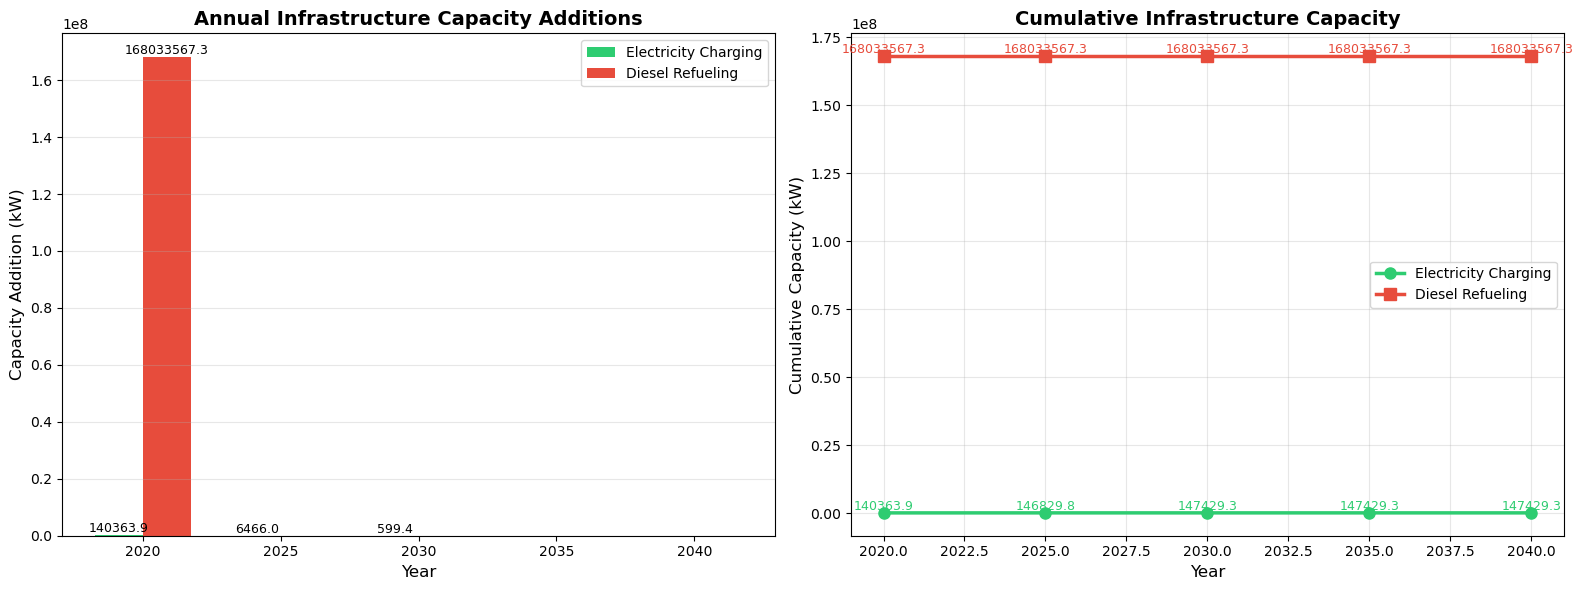


CAPACITY EXPANSION SUMMARY

Year       Electricity (kW)     Diesel (kW)          Cumulative Elec (kW)     
---------------------------------------------------------------------------
2020               140,363.88     168,033,567.30              140,363.88
2025                 6,465.96               0.00              146,829.85
2030                   599.43               0.00              147,429.28
2035                     0.00               0.00              147,429.28
2040                     0.00               0.00              147,429.28

---------------------------------------------------------------------------
TOTAL              147,429.28     168,033,567.30

📊 ANALYSIS:
  • Infrastructure additions occur only in year(s): [2020, 2025, 2030]
  • Total electricity charging capacity added: 147429.28 kW
  • Total diesel refueling capacity added: 168033567.30 kW
  • Investment strategy: Front-loaded


In [12]:
# Infrastructure Capacity Expansion by Year

import matplotlib.pyplot as plt
import numpy as np

# Aggregate capacity additions by year and fuel type
capacity_by_year = {}

for key, value in output_data["q_fuel_infr_plus"].items():
    year = key[0]
    f_l = key[1]  # (fuel_id, infr_id)
    fuel_id = f_l[0]
    
    # Get fuel name
    fuel_name = [k for k, v in fuel_list.items() if v["id"] == fuel_id][0]
    
    if year not in capacity_by_year:
        capacity_by_year[year] = {}
    
    if fuel_name not in capacity_by_year[year]:
        capacity_by_year[year][fuel_name] = 0
    
    capacity_by_year[year][fuel_name] += value

# Get all investment years from the model
investment_years_all = list(range(y_init, Y_end + 1, investment_period))
print(f"Investment years: {investment_years_all}")
print(f"Years with actual additions: {sorted(capacity_by_year.keys())}")

# Prepare data for plotting - include all investment years
fuel_types = ["electricity", "diesel"]
data_additions = {fuel: [capacity_by_year.get(y, {}).get(fuel, 0) for y in investment_years_all] for fuel in fuel_types}

# Calculate cumulative capacity
data_cumulative = {fuel: [] for fuel in fuel_types}
for fuel in fuel_types:
    cumsum = 0
    for val in data_additions[fuel]:
        cumsum += val
        data_cumulative[fuel].append(cumsum)

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Annual additions
x = np.arange(len(investment_years_all))
width = 0.35

bars1 = ax1.bar(x - width/2, data_additions["electricity"], width, label='Electricity Charging', color='#2ecc71')
bars2 = ax1.bar(x + width/2, data_additions["diesel"], width, label='Diesel Refueling', color='#e74c3c')

ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Capacity Addition (kW)', fontsize=12)
ax1.set_title('Annual Infrastructure Capacity Additions', fontsize=14, fontweight='bold')
ax1.set_xticks(x)
ax1.set_xticklabels(investment_years_all)
ax1.legend()
ax1.grid(axis='y', alpha=0.3)

# Add value labels on bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        if height > 0:
            ax1.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.1f}',
                   ha='center', va='bottom', fontsize=9)

# Plot 2: Cumulative capacity
ax2.plot(investment_years_all, data_cumulative["electricity"], marker='o', linewidth=2.5, 
         markersize=8, label='Electricity Charging', color='#2ecc71')
ax2.plot(investment_years_all, data_cumulative["diesel"], marker='s', linewidth=2.5,
         markersize=8, label='Diesel Refueling', color='#e74c3c')

ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Cumulative Capacity (kW)', fontsize=12)
ax2.set_title('Cumulative Infrastructure Capacity', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

# Add value labels on points
for i, year in enumerate(investment_years_all):
    for fuel, color in [("electricity", '#2ecc71'), ("diesel", '#e74c3c')]:
        val = data_cumulative[fuel][i]
        if val > 0:
            ax2.text(year, val, f'{val:.1f}', ha='center', va='bottom', fontsize=9, color=color)

plt.tight_layout()
plt.show()

# Print summary statistics
print("\n" + "="*80)
print("CAPACITY EXPANSION SUMMARY")
print("="*80)
print(f"\n{'Year':<10} {'Electricity (kW)':<20} {'Diesel (kW)':<20} {'Cumulative Elec (kW)':<25}")
print("-" * 75)
cumsum_elec = 0
cumsum_diesel = 0
for i, year in enumerate(investment_years_all):
    elec_cap = capacity_by_year.get(year, {}).get("electricity", 0)
    diesel_cap = capacity_by_year.get(year, {}).get("diesel", 0)
    cumsum_elec += elec_cap
    cumsum_diesel += diesel_cap
    print(f"{year:<10} {elec_cap:>18,.2f} {diesel_cap:>18,.2f} {cumsum_elec:>23,.2f}")

print("\n" + "-" * 75)
total_elec = sum(data_additions["electricity"])
total_diesel = sum(data_additions["diesel"])
print(f"{'TOTAL':<10} {total_elec:>18,.2f} {total_diesel:>18,.2f}")
print("="*80)

# Analysis
print("\n📊 ANALYSIS:")
print(f"  • Infrastructure additions occur only in year(s): {sorted(capacity_by_year.keys())}")
print(f"  • Total electricity charging capacity added: {total_elec:.2f} kW")
print(f"  • Total diesel refueling capacity added: {total_diesel:.2f} kW")
print(f"  • Investment strategy: {'Front-loaded' if 2020 in capacity_by_year else 'Gradual expansion'}")
if total_elec > 0 and len(capacity_by_year) == 1:
    print(f"  • The model adds all required electricity charging capacity upfront in {min(capacity_by_year.keys())}")
    print(f"    to serve demand throughout the planning horizon (2020-2040)")

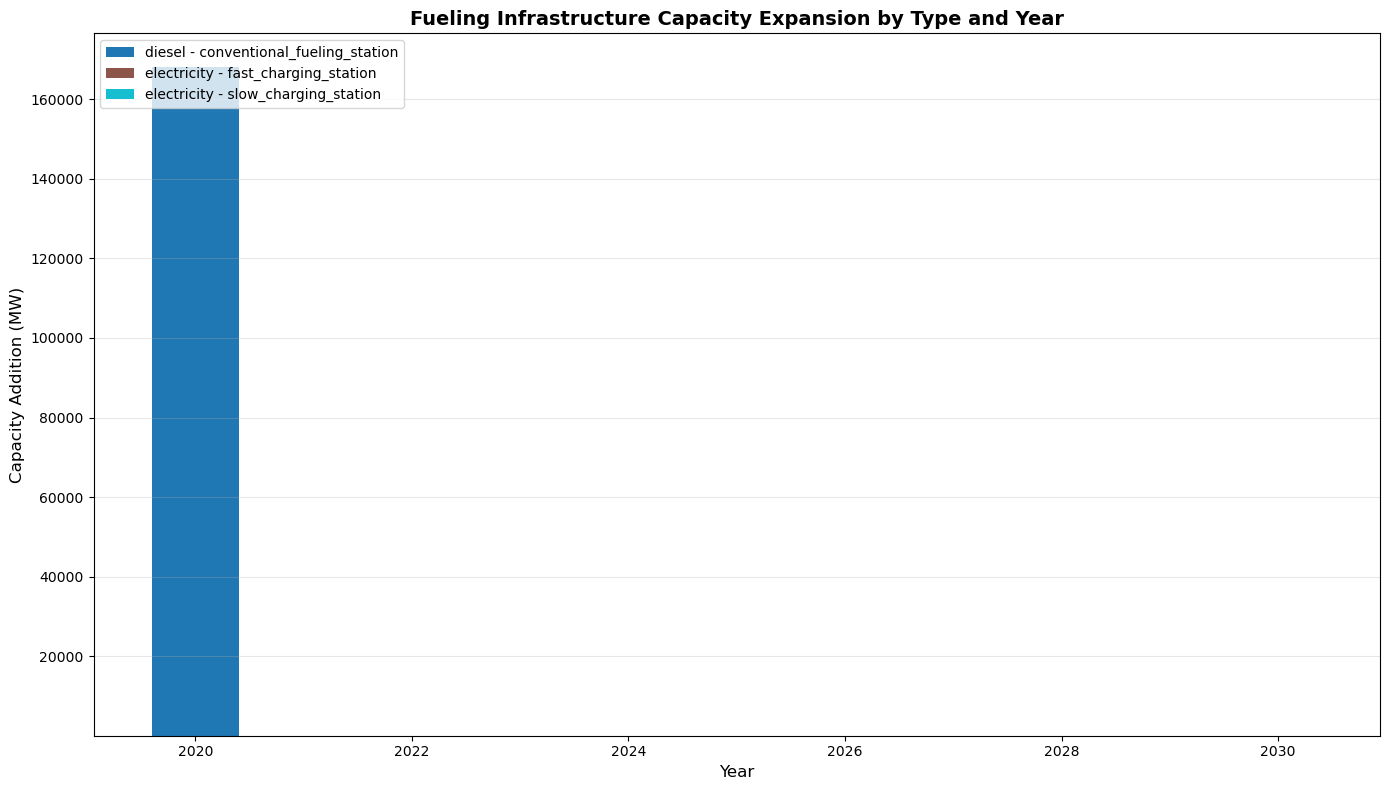

CAPACITY EXPANSION BY INFRASTRUCTURE TYPE (MW)
diesel - conventional_fueling_station:
  Total capacity added: 168,033.57 MW
  Years with expansion: [2020]
electricity - fast_charging_station:
  Total capacity added: 74.62 MW
  Years with expansion: [2020, 2025, 2030]
electricity - slow_charging_station:
  Total capacity added: 72.81 MW
  Years with expansion: [2020, 2025, 2030]


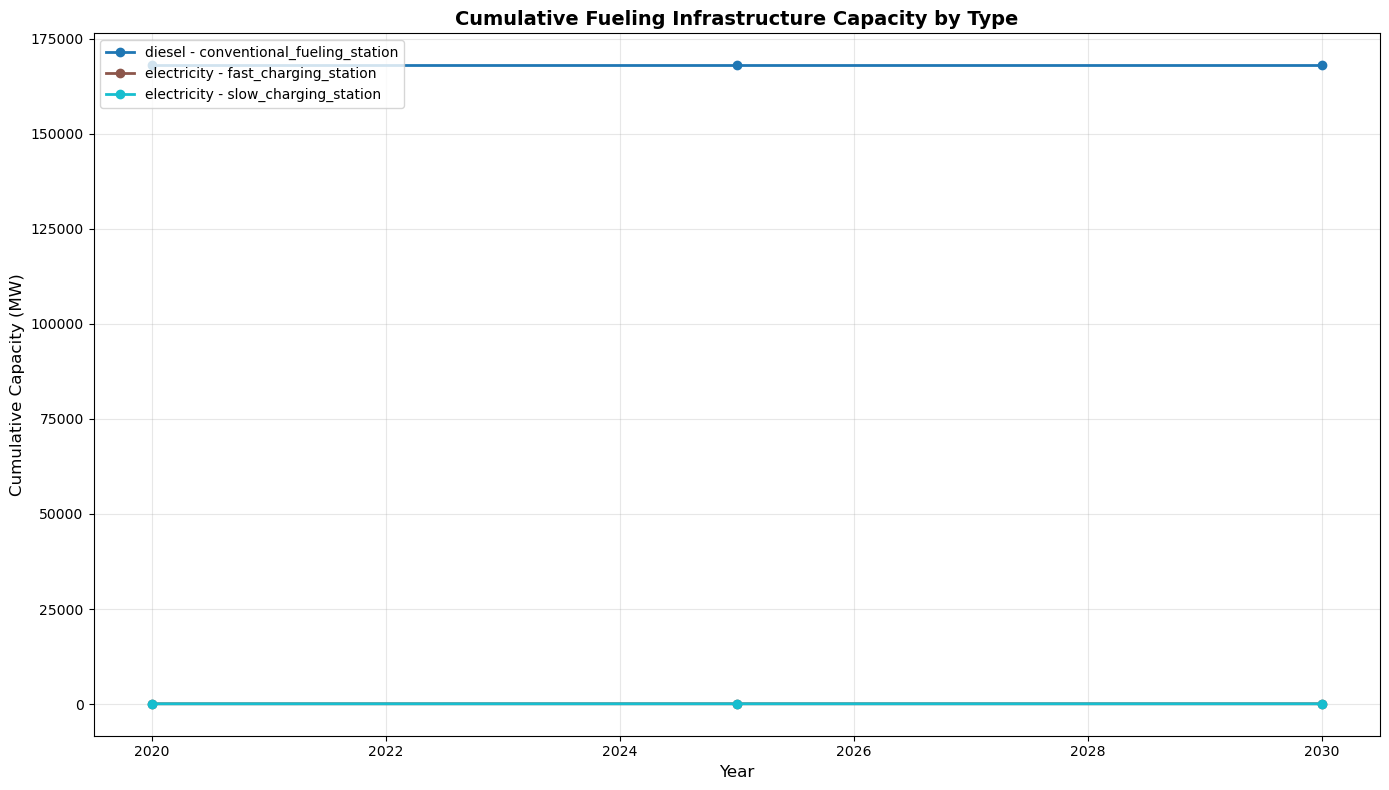

In [13]:
# Infrastructure Capacity Expansion by Type (not just fuel)

import matplotlib.pyplot as plt
import numpy as np

# Aggregate capacity additions by year and infrastructure type
capacity_by_type_year = {}

for key, value in output_data["q_fuel_infr_plus"].items():
    year = key[0]
    f_l = key[1]  # (fuel_id, infr_id)
    fuel_id = f_l[0]
    infr_id = f_l[1]
    
    # Get fuel name
    fuel_name = [k for k, v in fuel_list.items() if v["id"] == fuel_id][0]
    
    # Get infrastructure type name
    infr_type_name = fueling_infr_types_list[infr_id]["fueling_type"]
    
    # Create combined label: fuel + type
    type_label = f"{fuel_name} - {infr_type_name}"
    
    if year not in capacity_by_type_year:
        capacity_by_type_year[year] = {}
    
    if type_label not in capacity_by_type_year[year]:
        capacity_by_type_year[year][type_label] = 0
    
    capacity_by_type_year[year][type_label] += value

# Prepare data for plotting
years = sorted(capacity_by_type_year.keys())
type_labels = sorted(set(label for year_data in capacity_by_type_year.values() for label in year_data.keys()))

# Create matrix for stacked bar chart
data_matrix = np.zeros((len(type_labels), len(years)))
for i, type_label in enumerate(type_labels):
    for j, year in enumerate(years):
        data_matrix[i, j] = capacity_by_type_year[year].get(type_label, 0) / 1000  # Convert to MW

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))

# Define colors for each infrastructure type
colors = plt.cm.tab10(np.linspace(0, 1, len(type_labels)))

bottom = np.zeros(len(years))
for i, type_label in enumerate(type_labels):
    ax.bar(years, data_matrix[i], bottom=bottom, label=type_label, color=colors[i])
    bottom += data_matrix[i]

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Capacity Addition (MW)', fontsize=12)
ax.set_title('Fueling Infrastructure Capacity Expansion by Type and Year', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Also create a breakdown table
print("" + "="*80)
print("CAPACITY EXPANSION BY INFRASTRUCTURE TYPE (MW)")
print("="*80)
for type_label in type_labels:
    total_added = sum(capacity_by_type_year[year].get(type_label, 0) for year in years) / 1000
    print(f"{type_label}:") 
    print(f"  Total capacity added: {total_added:,.2f} MW")
    print(f"  Years with expansion: {[year for year in years if capacity_by_type_year[year].get(type_label, 0) > 0]}")

# Cumulative capacity over time
fig, ax = plt.subplots(figsize=(14, 8))

for i, type_label in enumerate(type_labels):
    cumulative = np.cumsum(data_matrix[i])
    ax.plot(years, cumulative, marker='o', linewidth=2, label=type_label, color=colors[i])

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cumulative Capacity (MW)', fontsize=12)
ax.set_title('Cumulative Fueling Infrastructure Capacity by Type', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


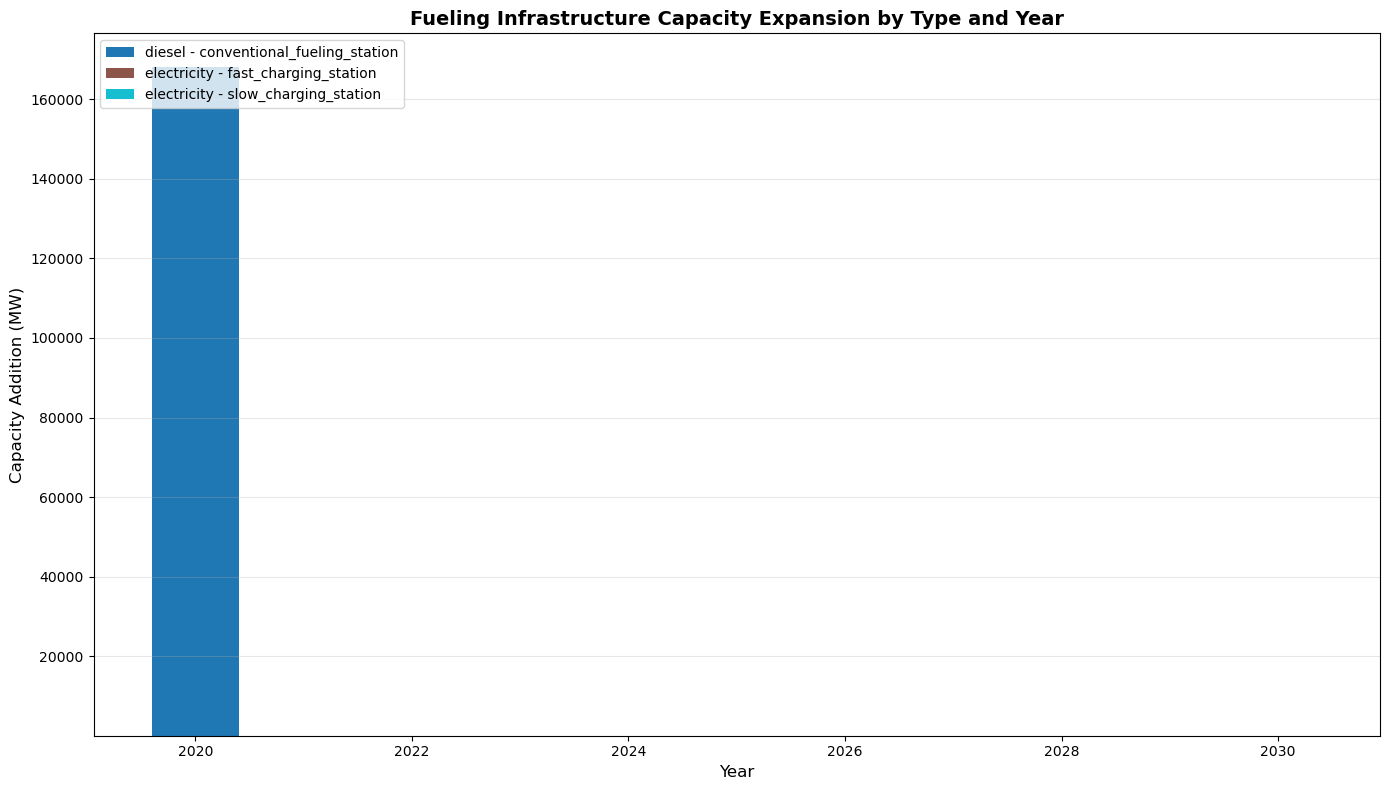

CAPACITY EXPANSION BY INFRASTRUCTURE TYPE (MW)
diesel - conventional_fueling_station:
  Total capacity added: 168,033.57 MW
  Years with expansion: [2020]
electricity - fast_charging_station:
  Total capacity added: 74.62 MW
  Years with expansion: [2020, 2025, 2030]
electricity - slow_charging_station:
  Total capacity added: 72.81 MW
  Years with expansion: [2020, 2025, 2030]


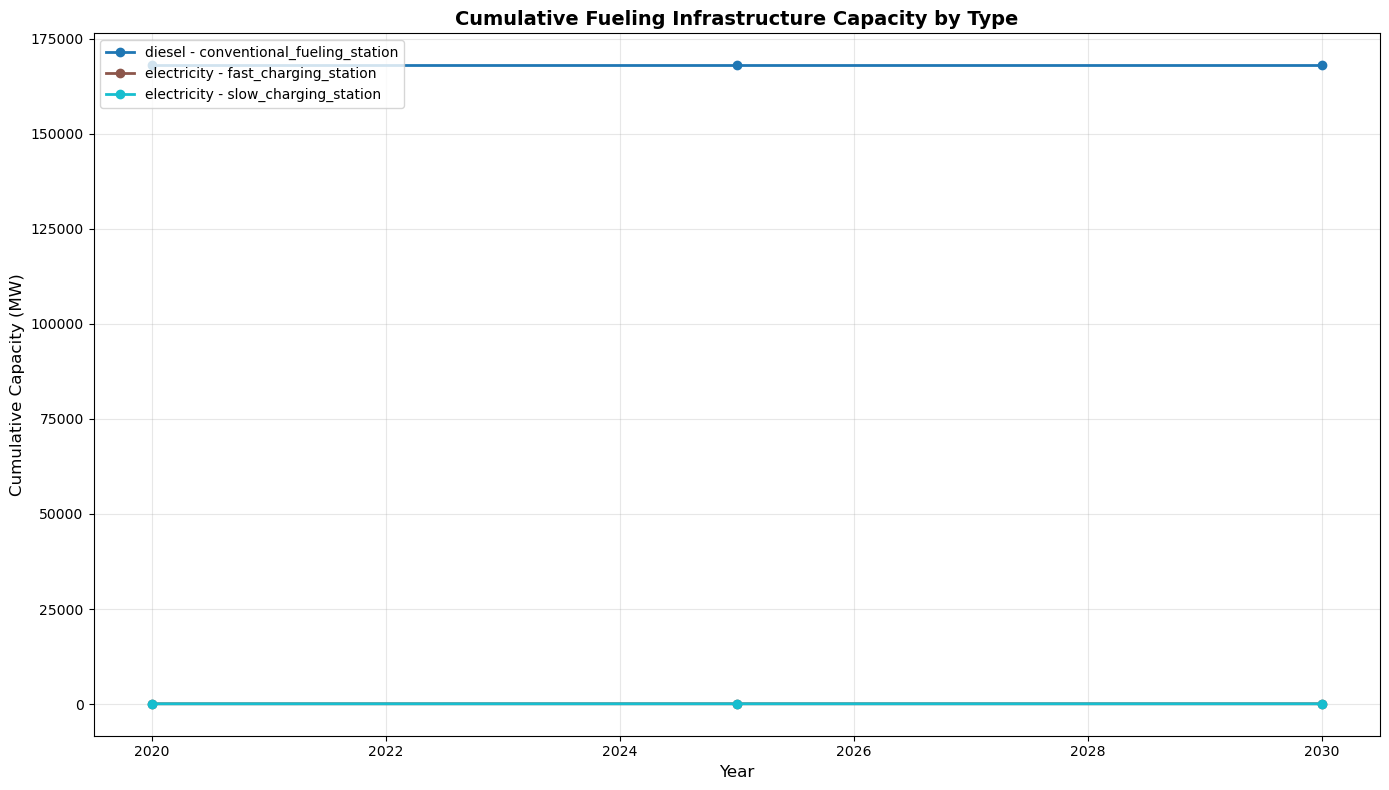

In [14]:
# Infrastructure Capacity Expansion by Type (not just fuel)

import matplotlib.pyplot as plt
import numpy as np

# Aggregate capacity additions by year and infrastructure type
capacity_by_type_year = {}

for key, value in output_data["q_fuel_infr_plus"].items():
    year = key[0]
    f_l = key[1]  # (fuel_id, infr_id)
    fuel_id = f_l[0]
    infr_id = f_l[1]
    
    # Get fuel name
    fuel_name = [k for k, v in fuel_list.items() if v["id"] == fuel_id][0]
    
    # Get infrastructure type name
    infr_type_name = fueling_infr_types_list[infr_id]["fueling_type"]
    
    # Create combined label: fuel + type
    type_label = f"{fuel_name} - {infr_type_name}"
    
    if year not in capacity_by_type_year:
        capacity_by_type_year[year] = {}
    
    if type_label not in capacity_by_type_year[year]:
        capacity_by_type_year[year][type_label] = 0
    
    capacity_by_type_year[year][type_label] += value

# Prepare data for plotting
years = sorted(capacity_by_type_year.keys())
type_labels = sorted(set(label for year_data in capacity_by_type_year.values() for label in year_data.keys()))

# Create matrix for stacked bar chart
data_matrix = np.zeros((len(type_labels), len(years)))
for i, type_label in enumerate(type_labels):
    for j, year in enumerate(years):
        data_matrix[i, j] = capacity_by_type_year[year].get(type_label, 0) / 1000  # Convert to MW

# Create stacked bar chart
fig, ax = plt.subplots(figsize=(14, 8))

# Define colors for each infrastructure type
colors = plt.cm.tab10(np.linspace(0, 1, len(type_labels)))

bottom = np.zeros(len(years))
for i, type_label in enumerate(type_labels):
    ax.bar(years, data_matrix[i], bottom=bottom, label=type_label, color=colors[i])
    bottom += data_matrix[i]

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Capacity Addition (MW)', fontsize=12)
ax.set_title('Fueling Infrastructure Capacity Expansion by Type and Year', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Also create a breakdown table
print("" + "="*80)
print("CAPACITY EXPANSION BY INFRASTRUCTURE TYPE (MW)")
print("="*80)
for type_label in type_labels:
    total_added = sum(capacity_by_type_year[year].get(type_label, 0) for year in years) / 1000
    print(f"{type_label}:")
    print(f"  Total capacity added: {total_added:,.2f} MW")
    print(f"  Years with expansion: {[year for year in years if capacity_by_type_year[year].get(type_label, 0) > 0]}")

# Cumulative capacity over time
fig, ax = plt.subplots(figsize=(14, 8))

for i, type_label in enumerate(type_labels):
    cumulative = np.cumsum(data_matrix[i])
    ax.plot(years, cumulative, marker='o', linewidth=2, label=type_label, color=colors[i])

ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Cumulative Capacity (MW)', fontsize=12)
ax.set_title('Cumulative Fueling Infrastructure Capacity by Type', fontsize=14, fontweight='bold')
ax.legend(loc='upper left', fontsize=10)
ax.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [15]:
import geopandas as gpd
import matplotlib.pyplot as plt
import os
import pandas as pd
from shapely.geometry import Point

# Create a GeoDataFrame from the geographic elements
# Collect geographic elements from all odpairs
geographic_element_list = {d["id"]: d for d in input_data["GeographicElement"]}
rel_geographic_elements = []
for odpair_id, odpair_data in odpair_list.items():
    path_id = odpair_data["path_id"]
    path_data = path_list[path_id]
    rel_geographic_elements.extend(path_data["sequence"])

# Remove duplicates and create GeoDataFrame
rel_geographic_elements = list(set(rel_geographic_elements))
rel_geo_elem_list = []
for geo_id in geographic_element_list.keys():
    if geo_id in rel_geographic_elements:
        rel_geo_elem_list.append(geographic_element_list[geo_id])

geometry = [Point(geo["coordinate_long"], geo["coordinate_lat"]) for geo in rel_geo_elem_list]
geo_df = gpd.GeoDataFrame({'GeoID': [geo["id"] for geo in rel_geo_elem_list]}, geometry=geometry)

print(geo_df.head())

   GeoID                   geometry
0      0  POINT (13.98372 48.13096)
1      1    POINT (13.235 47.40583)
2      2  POINT (11.42974 47.18178)
3      3   POINT (9.84334 47.27175)
4      4   POINT (9.51227 48.95892)


In [16]:
geo_f = geographic_element_list  # Assuming geo_f is the geographic element list
fueling_infr_dataframes = []

# Iterate over years and fuels
for year in range(y_init, Y_end + 1):
    for fuel_id, fuel_data in fuel_list.items():
        fuel_name = fuel_data["name"]
        records = []

        # Iterate over geographic elements
        for geo_id, geo_data in geo_f.items():
            # Iterate over infrastructure types for the current fuel
            for infr_id, infr_data in fueling_infr_types_list.items():
                if infr_data["fuel"] == fuel_name:
                    f_l = (fuel_id, infr_id)
                    key_q = (year, f_l, geo_id)

                    # Check if the key exists in q_fuel_infr_plus
                
                    installed_capacity = sum(output_data["q_fuel_infr_plus"].get((y, f_l, geo_id), 0) for y in range(y_init, year + 1))

                    # Append data for the GeoDataFrame
                    records.append({
                        "GeoID": geo_id,
                        "Year": year,
                        "Fuel": fuel_name,
                        "InfrastructureType": infr_id,
                        "InstalledCapacity": installed_capacity,
                        "Latitude": geo_data["coordinate_lat"],
                        "Longitude": geo_data["coordinate_long"]
                    })

        # Create GeoDataFrame for the current year and fuel
        if records:
            gdf = gpd.GeoDataFrame(
                records,
                geometry=gpd.points_from_xy(
                    [record["Longitude"] for record in records],
                    [record["Latitude"] for record in records]
                )
            )
            fueling_infr_dataframes.append(gdf)
            print(gdf.head())

# Now fueling_infr_dataframes contains a list of GeoDataFrames for each year and fuel
print(f"Generated {len(fueling_infr_dataframes)} GeoDataFrames.")

   GeoID  Year         Fuel  InfrastructureType  InstalledCapacity   Latitude  \
0      0  2020  electricity                   1                  0  48.130960   
1      0  2020  electricity                   2                  0  48.130960   
2      1  2020  electricity                   1                  0  47.405833   
3      1  2020  electricity                   2                  0  47.405833   
4      2  2020  electricity                   1                  0  47.181780   

   Longitude                   geometry  
0   13.98372  POINT (13.98372 48.13096)  
1   13.98372  POINT (13.98372 48.13096)  
2   13.23500    POINT (13.235 47.40583)  
3   13.23500    POINT (13.235 47.40583)  
4   11.42974  POINT (11.42974 47.18178)  
   GeoID  Year    Fuel  InfrastructureType  InstalledCapacity   Latitude  \
0      0  2020  diesel                   0                  0  48.130960   
1      1  2020  diesel                   0                  0  47.405833   
2      2  2020  diesel           

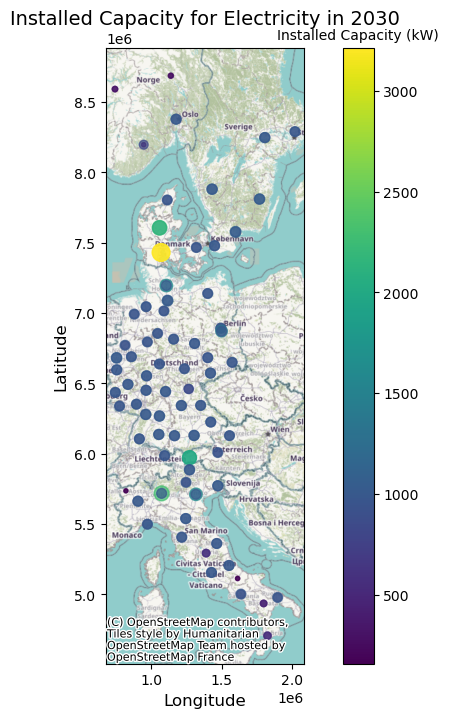

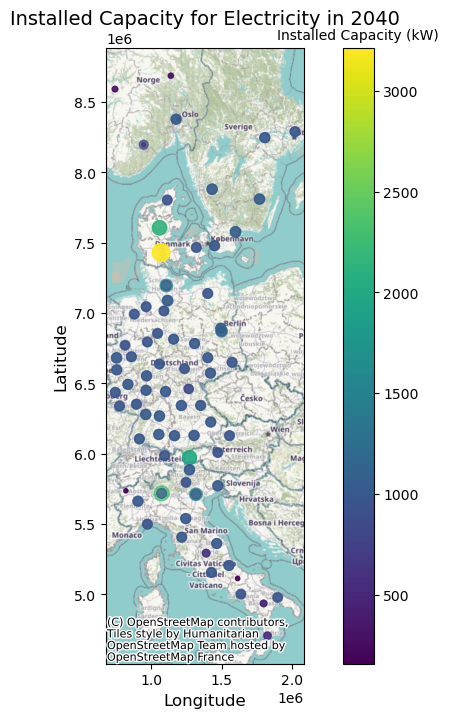

In [17]:
# Filter data for fuel 'electricity' and year 2040
import contextily as cx
# Define the years to display
years_to_display = [2030, 2040]

for year in years_to_display:
    filtered_records = []

    for geo_id, geo_data in geographic_element_list.items():
        for infr_id, infr_data in fueling_infr_types_list.items():
            if infr_data["fuel"] == "electricity":  # Fixed: use actual fuel name
                f_l = (fuel_list["electricity"]["id"], infr_id)
                installed_capacity = sum(output_data["q_fuel_infr_plus"].get((y, f_l, geo_id), 0) for y in range(y_init, year + 1))
                if installed_capacity > 0:
                    filtered_records.append({
                        "GeoID": geo_id,
                        "InstalledCapacity": installed_capacity,
                        "Latitude": geo_data["coordinate_lat"],
                        "Longitude": geo_data["coordinate_long"]
                    })

    # Only plot if there are records
    if len(filtered_records) > 0:
        # Create GeoDataFrame for the filtered data
        filtered_gdf = gpd.GeoDataFrame(
            filtered_records,
            geometry=gpd.points_from_xy(
                [record["Longitude"] for record in filtered_records],
                [record["Latitude"] for record in filtered_records],
            ),
            crs="EPSG:4326"
        )
        filtered_gdf = filtered_gdf.to_crs(epsg=3857)
       
        # Plot the data on a map
        base = filtered_gdf.plot(
            column="InstalledCapacity",
            cmap="viridis",
            legend=True,
            figsize=(10, 8),
            markersize=filtered_gdf["InstalledCapacity"] * 0.05,
            alpha=0.7
        )
        colorbar = base.get_figure().get_axes()[-1]
        colorbar.set_title("Installed Capacity (kW)", fontsize=10)
        cx.add_basemap(base)
        base.set_title(f"Installed Capacity for Electricity in {year}", fontsize=14)
        base.set_xlabel("Longitude", fontsize=12)
        base.set_ylabel("Latitude", fontsize=12)
        plt.show()
    else:
        print(f"No electricity infrastructure capacity added in year {year}")


        # Adjust marker size based on installed capacity
        

### Verifying SOC (State of Charge) Constraints

The newly added constraints `constraint_soc_max` and `constraint_soc_track` ensure that:
1. **SOC ≤ tank_capacity**: State of charge never exceeds vehicle tank/battery capacity
2. **SOC tracking along routes**: SOC decreases with distance traveled (energy consumption) and increases when charging/refueling

This verification checks these constraints for sample routes.

In [18]:
# SOC Constraint Verification - CORRECTED VERSION
# This validates that constraint_soc_max and constraint_soc_track are working properly

print("="*80)
print("STATE OF CHARGE (SOC) CONSTRAINT VERIFICATION - CORRECTED")
print("="*80)

# Check if soc data exists
if "soc" not in output_data or len(output_data["soc"]) == 0:
    print("\n⚠️  No SOC data found in results!")
    print("   Possible reasons:")
    print("   - The soc variable was not saved")
    print("   - The constraints were not active in the model")
    print("   - No electric vehicles were used")
else:
    print(f"\n✓ Found {len(output_data['soc'])} SOC entries")

    # Get fuel infrastructure pairs for tracking
    f_l_pairs = set()
    for l_id, l_data in fueling_infr_types_list.items():
        fuel_name = l_data["fuel"]
        fuel_id = fuel_list[fuel_name]["id"]
        f_l_pairs.add((fuel_id, l_id))

    print(f"  Fuel-infrastructure pairs: {sorted(f_l_pairs)}")

    # Verify SOC constraints for a sample of paths
    sample_paths = list(path_list.keys())[:3]  # Check first 3 paths
    print(f"\n  Analyzing {len(sample_paths)} sample paths")

    violations_soc_max = []
    violations_soc_track = []
    violations_soc_min = []  # Track SOC < 50% at destination
    successful_checks = 0

    for path_id in sample_paths:
        path_data = path_list[path_id]
        sequence = path_data["sequence"]
        cumulative_distance = path_data.get("cumulative_distance", [0] * len(sequence))
        distance_from_previous = path_data.get("distance_from_previous", [0] * len(sequence))

        print(f"\n{'='*80}")
        print(f"PATH {path_id}: {path_data.get('name', 'N/A')}")
        print(f"  Total length: {path_data['length']:.2f} km")
        print(f"  Number of nodes: {len(sequence)}")
        print(f"{'='*80}")

        # Find OD pairs using this path
        odpairs_on_path = [(r_id, r_data) for r_id, r_data in odpair_list.items()
                          if r_data["path_id"] == path_id]

        if len(odpairs_on_path) == 0:
            print(f"  ⚠️  No OD pairs use this path")
            continue

        print(f"  Found {len(odpairs_on_path)} OD pair(s) using this path")

        # Check SOC for specific years
        test_years = [2030, 2040]

        for year in test_years:
            print(f"\n  {'─'*76}")
            print(f"  YEAR {year}")
            print(f"  {'─'*76}")

            for tv_id, tv_data in techvehicle_list.items():
                tech_id = tv_data["technology"]
                tech_data = technology_list[tech_id]
                fuel_name = tech_data["fuel"]
                fuel_id = fuel_list[fuel_name]["id"]

                # Get vehicle parameters for this year/generation
                idx_year = min(year - y_init, len(tv_data.get("tank_capacity", [100])) - 1)
                tank_capacity_single = tv_data.get("tank_capacity", [100])[idx_year] if isinstance(tv_data.get("tank_capacity"), list) else tv_data.get("tank_capacity", 100)

                # Find matching fuel-infrastructure pair
                f_l = None
                for fl in f_l_pairs:
                    if fl[0] == fuel_id:
                        f_l = fl
                        break

                if f_l is None:
                    continue

                # Check if this vehicle has any flow on this path in this year
                has_flow = False
                total_flow = 0
                for r_id, r_data in odpairs_on_path:
                    # IMPORTANT: Check g <= year as per constraint definition
                    for gen in range(g_init, year + 1):  # g <= year
                        key_f = (year, (0, r_id, path_id), (1, tv_id), gen)
                        if key_f in output_data["f"]:
                            flow_val = output_data["f"][key_f]
                            if flow_val > 0.01:
                                has_flow = True
                                total_flow += flow_val

                if not has_flow:
                    continue  # Skip vehicles with no flow

                print(f"\n    {tv_data['name']} ({fuel_name}, fuel_id={fuel_id})")
                print(f"      Tank capacity (single vehicle): {tank_capacity_single:.2f} kWh")
                print(f"      Total flow in year {year}: {total_flow:.4f} (thousands of tons)")

                # Get spec_cons for checking energy consumption
                idx_gen_2030 = min(2030 - g_init, len(tv_data.get("spec_cons", [0.5])) - 1)
                spec_cons = tv_data.get("spec_cons", [0.5])[idx_gen_2030] if isinstance(tv_data.get("spec_cons"), list) else tv_data.get("spec_cons", 0.5)
                W = tv_data.get("W", [1.0])[idx_gen_2030] if isinstance(tv_data.get("W"), list) else tv_data.get("W", 1.0)
                annual_range = tv_data.get("AnnualRange", [50000])[idx_gen_2030] if isinstance(tv_data.get("AnnualRange"), list) else tv_data.get("AnnualRange", 50000)

                print(f"      Spec. consumption: {spec_cons:.4f} kWh/km, W: {W:.2f}, AnnualRange: {annual_range:.0f} km")

                # For each OD pair on this path
                for r_id, r_data in odpairs_on_path:
                    # CHANGED: Create separate SOC profiles for each generation
                    # OLD: soc_profile = []
                    # NEW: Dictionary that maps generation -> list of SOC entries
                    soc_profiles_by_gen = {}

                    # Check generations g <= year (as per constraint)
                    for gen in range(g_init, year + 1):
                        # Initialize empty profile for this generationW
                        soc_profiles_by_gen[gen] = []

                        # Calculate expected fleet size for this generation
                        key_f = (year, (0, r_id, path_id), (1, tv_id), gen)
                        if key_f not in output_data["f"]:
                            continue

                        flow = output_data["f"][key_f]
                        if flow < 0.01:
                            continue

                        # Get parameters for THIS generation
                        idx_gen = gen - g_init
                        W_gen = tv_data.get("W", [1.0])[idx_gen] if isinstance(tv_data.get("W"), list) else tv_data.get("W", 1.0)
                        annual_range_gen = tv_data.get("AnnualRange", [50000])[idx_gen] if isinstance(tv_data.get("AnnualRange"), list) else tv_data.get("AnnualRange", 50000)
                        tank_capacity_gen = tv_data.get("tank_capacity", [100])[idx_gen] if isinstance(tv_data.get("tank_capacity"), list) else tv_data.get("tank_capacity", 100)
                        spec_cons_gen = tv_data.get("spec_cons", [0.5])[idx_gen] if isinstance(tv_data.get("spec_cons"), list) else tv_data.get("spec_cons", 0.5)

                        num_vehicles = (path_data['length'] / (W_gen * annual_range_gen)) * 1000 * flow
                        fleet_tank_capacity = tank_capacity_gen * num_vehicles

                        # Check SOC values along the route FOR THIS GENERATION ONLY
                        for i, geo_id in enumerate(sequence):
                            key_soc = (year, (0, r_id, path_id, geo_id), tv_id, f_l, gen)

                            if key_soc in output_data["soc"]:
                                soc_val = output_data["soc"][key_soc]
                                cum_dist = cumulative_distance[i] if i < len(cumulative_distance) else 0

                                # Check constraint_soc_max: SOC <= fleet_tank_capacity
                                if soc_val > fleet_tank_capacity + 1e-3:  # tolerance for numerical errors
                                    violations_soc_max.append({
                                        'year': year,
                                        'path_id': path_id,
                                        'odpair': r_id,
                                        'tv_id': tv_id,
                                        'gen': gen,
                                        'node_idx': i,
                                        'geo_id': geo_id,
                                        'soc': soc_val,
                                        'fleet_capacity': fleet_tank_capacity,
                                        'excess': soc_val - fleet_tank_capacity,
                                        'cum_dist': cum_dist
                                    })

                                # Check constraint_soc_min: SOC >= 50% of capacity at destination
                                is_destination = (i == len(sequence) - 1)
                                if is_destination:
                                    min_required_soc = fleet_tank_capacity * 0.5
                                    if soc_val < min_required_soc - 1e-3:
                                        violations_soc_min.append({
                                            'year': year,
                                            'path_id': path_id,
                                            'odpair': r_id,
                                            'tv_id': tv_id,
                                            'gen': gen,
                                            'geo_id': geo_id,
                                            'soc': soc_val,
                                            'fleet_capacity': fleet_tank_capacity,
                                            'min_required': min_required_soc,
                                            'shortfall': min_required_soc - soc_val,
                                            'percent': 100 * soc_val / fleet_tank_capacity
                                        })

                                # Add to THIS generation's SOC profile
                                soc_profiles_by_gen[gen].append({
                                    'node_idx': i,
                                    'geo_id': geo_id,
                                    'soc': soc_val,
                                    'fleet_capacity': fleet_tank_capacity,
                                    'cum_dist': cum_dist,
                                    'gen': gen,
                                    'num_vehicles': num_vehicles
                                })
                                successful_checks += 1  # Count each SOC entry checked

                    # NOW PRINT EACH GENERATION'S PROFILE SEPARATELY
                    for gen in sorted(soc_profiles_by_gen.keys()):
                        soc_profile = soc_profiles_by_gen[gen]

                        if len(soc_profile) == 0:
                            continue  # Skip generations with no SOC data

                        # Get parameters for THIS generation for printing
                        idx_gen = gen - g_init
                        W_gen = tv_data.get("W", [1.0])[idx_gen] if isinstance(tv_data.get("W"), list) else tv_data.get("W", 1.0)
                        annual_range_gen = tv_data.get("AnnualRange", [50000])[idx_gen] if isinstance(tv_data.get("AnnualRange"), list) else tv_data.get("AnnualRange", 50000)
                        tank_capacity_gen = tv_data.get("tank_capacity", [100])[idx_gen] if isinstance(tv_data.get("tank_capacity"), list) else tv_data.get("tank_capacity", 100)
                        spec_cons_gen = tv_data.get("spec_cons", [0.5])[idx_gen] if isinstance(tv_data.get("spec_cons"), list) else tv_data.get("spec_cons", 0.5)

                        key_f = (year, (0, r_id, path_id), (1, tv_id), gen)
                        flow = output_data["f"][key_f]
                        num_vehicles = (path_data['length'] / (W_gen * annual_range_gen)) * 1000 * flow
                        fleet_tank_capacity = tank_capacity_gen * num_vehicles

                        print(f"\n      Generation {gen} (bought in {gen}):")
                        print(f"        Number of vehicles: {num_vehicles:.2f}")
                        print(f"        Fleet tank capacity: {fleet_tank_capacity:.2f} kWh")
                        print(f"        SOC profile ({len(soc_profile)} nodes):")
                        print(f"        {'Node':<6} {'Geo ID':<8} {'Dist (km)':>10}  {'SOC (kWh)':>12}  {'% of Fleet Cap':>15}")
                        print(f"        {'-'*60}")

                        # Show first 5 and last 5 nodes
                        nodes_to_show = list(range(min(5, len(soc_profile)))) + list(range(max(5, len(soc_profile) - 5), len(soc_profile)))
                        nodes_to_show = sorted(set(nodes_to_show))

                        for idx in nodes_to_show:
                            if idx < len(soc_profile):
                                entry = soc_profile[idx]
                                pct_full = (entry['soc'] / entry['fleet_capacity'] * 100) if entry['fleet_capacity'] > 0 else 0
                                print(f"        {entry['node_idx']:<6} {entry['geo_id']:<8} {entry['cum_dist']:>10.2f}  {entry['soc']:>12.2f}  {pct_full:>14.1f}%")

                        if len(soc_profile) > 10:
                            print(f"        ... {len(soc_profile) - 10} nodes omitted ...")

                        # SOC Tracking Verification (first 5 transitions)
                        if len(soc_profile) > 1:
                            print(f"\n        SOC Tracking Verification (first 5 transitions):")
                            print(f"        {'Transition':<15} {'ΔDistance':<12} {'ΔSOC':<12} {'Expected ΔE':<15} {'Charging':<12} {'Balance':<10}")
                            print(f"        {'-'*80}")

                            for j in range(1, min(6, len(soc_profile))):
                                prev_soc = soc_profile[j-1]['soc']
                                curr_soc = soc_profile[j]['soc']
                                prev_geo = soc_profile[j-1]['geo_id']
                                curr_geo = soc_profile[j]['geo_id']

                                dist_increment = soc_profile[j]['cum_dist'] - soc_profile[j-1]['cum_dist']
                                soc_change = curr_soc - prev_soc

                                # Expected energy consumption FOR THIS GENERATION
                                expected_energy_loss = dist_increment * spec_cons_gen * num_vehicles

                                # Check if charging occurred at current node
                                key_s = (year, (0, r_id, path_id, curr_geo), tv_id, f_l, gen)
                                charging = output_data["s"].get(key_s, 0) * 1000  # Convert to kWh

                                # SOC balance: SOC_curr = SOC_prev - energy_consumed + charging
                                expected_soc_change = -expected_energy_loss + charging
                                balance_error = abs(soc_change - expected_soc_change)

                                transition_label = f"{j-1}→{j}"
                                status = "✓" if balance_error < 1e-2 else "✗"

                                print(f"        {transition_label:<15} {dist_increment:>10.2f}  {soc_change:>10.2f}  {-expected_energy_loss:>13.2f}  {charging:>10.2f}  {status} {balance_error:.4f}")

                                # Record violations
                                if balance_error >= 1e-2:
                                    violations_soc_track.append({
                                        'year': year,
                                        'path_id': path_id,
                                        'odpair': r_id,
                                        'tv_id': tv_id,
                                        'gen': gen,
                                        'transition': f"{j-1}→{j}",
                                        'prev_geo': prev_geo,
                                        'curr_geo': curr_geo,
                                        'soc_change': soc_change,
                                        'expected_change': expected_soc_change,
                                        'error': balance_error
                                    })

print(f"\n{'='*80}")
print(f"VERIFICATION SUMMARY")
print(f"{'='*80}")
print(f"Total SOC entries checked: {successful_checks}")
print(f"SOC_MAX violations: {len(violations_soc_max)}")
print(f"SOC_MIN violations (destination < 50%): {len(violations_soc_min)}")
print(f"SOC_TRACK violations: {len(violations_soc_track)}")

if len(violations_soc_max) > 0:
    print(f"\n⚠️  SOC_MAX VIOLATIONS (SOC > fleet capacity):")
    print(f"{'Year':<6} {'Path':<6} {'OD':<6} {'TV':<6} {'Gen':<6} {'Node':<6} {'GeoID':<8} {'SOC':<12} {'Capacity':<12} {'Excess':<10}")
    print("-" * 90)
    for v in violations_soc_max[:10]:
        print(f"{v['year']:<6} {v['path_id']:<6} {v['odpair']:<6} {v['tv_id']:<6} {v['gen']:<6} {v['node_idx']:<6} {v['geo_id']:<8} {v['soc']:>10.2f} {v['fleet_capacity']:>10.2f} {v['excess']:>8.4f}")
    if len(violations_soc_max) > 10:
        print(f"... and {len(violations_soc_max) - 10} more violations")

if len(violations_soc_min) > 0:
    print(f"\n⚠️  SOC_MIN VIOLATIONS (SOC < 50% at destination):")
    print(f"{'Year':<6} {'Path':<6} {'OD':<6} {'TV':<6} {'Gen':<6} {'GeoID':<8} {'SOC':<12} {'Min Req':<12} {'Shortfall':<12} {'%Cap':<8}")
    print("-" * 95)
    for v in violations_soc_min[:10]:
        print(f"{v['year']:<6} {v['path_id']:<6} {v['odpair']:<6} {v['tv_id']:<6} {v['gen']:<6} {v['geo_id']:<8} {v['soc']:>10.2f} {v['min_required']:>10.2f} {v['shortfall']:>10.2f} {v['percent']:>6.1f}%")
    if len(violations_soc_min) > 10:
        print(f"... and {len(violations_soc_min) - 10} more violations")

if len(violations_soc_track) > 0:
    print(f"\n⚠️  SOC_TRACK VIOLATIONS (energy balance errors):")
    print(f"{'Year':<6} {'Path':<6} {'OD':<6} {'TV':<6} {'Gen':<6} {'Transition':<12} {'ΔSOC':<12} {'Expected':<12} {'Error':<10}")
    print("-" * 90)
    for v in violations_soc_track[:10]:
        print(f"{v['year']:<6} {v['path_id']:<6} {v['odpair']:<6} {v['tv_id']:<6} {v['gen']:<6} {v['transition']:<12} {v['soc_change']:>10.2f} {v['expected_change']:>10.2f} {v['error']:>8.4f}")
    if len(violations_soc_track) > 10:
        print(f"... and {len(violations_soc_track) - 10} more violations")

if len(violations_soc_max) == 0 and len(violations_soc_track) == 0:
    print(f"\n✅ All SOC constraints are satisfied!")
    print(f"   - SOC values never exceed fleet tank capacity")
    print(f"   - SOC tracking correctly accounts for energy consumption and charging")
else:
    print(f"\n❌ SOC constraint violations detected!")
    print(f"   Please review the constraint implementation.")

print(f"\n{'='*80}")
print(f"END OF SOC VERIFICATION")
print(f"{'='*80}")

STATE OF CHARGE (SOC) CONSTRAINT VERIFICATION - CORRECTED

✓ Found 32916 SOC entries
  Fuel-infrastructure pairs: [(0, 1), (0, 2), (1, 0)]

  Analyzing 3 sample paths

PATH 0: path_0_47_to_47
  Total length: 562.75 km
  Number of nodes: 1
  Found 1 OD pair(s) using this path

  ────────────────────────────────────────────────────────────────────────────
  YEAR 2030
  ────────────────────────────────────────────────────────────────────────────

    ICEV (diesel, fuel_id=1)
      Tank capacity (single vehicle): 5529.00 kWh
      Total flow in year 2030: 984.8388 (thousands of tons)
      Spec. consumption: 227.6590 kWh/km, W: 13.60, AnnualRange: 136750 km

  ────────────────────────────────────────────────────────────────────────────
  YEAR 2040
  ────────────────────────────────────────────────────────────────────────────

    ICEV (diesel, fuel_id=1)
      Tank capacity (single vehicle): 5529.00 kWh
      Total flow in year 2040: 984.8388 (thousands of tons)
      Spec. consumption: 22

In [19]:
# Get the path_id for odpair with id = 0
path_id = odpair_list[0]["path_id"]

# Get the sequence for the path
path_sequence = path_list[path_id]["sequence"]

# Extract all keys from soc that correspond to odpair with id = 0
soc_keys = {key[1][3] for key in output_data["soc"].keys() if key[1][1] == 0}

# Check if all items in the path sequence are in the soc keys
all_in_keys = all(geo_id in soc_keys for geo_id in path_sequence)

print(f"All items from path sequence are in the keys of soc: {all_in_keys}")
print(soc_keys)
# Filter and print all SOC keys that match the pattern (0, 1, 1, geo_id) where geo_id is in the sequence
matching_keys = [key for key in output_data["soc"].keys() for elem in path_sequence if key[1] == (0, 1, 1, elem)]
print("Matching SOC keys:")
for key in matching_keys:
    value = output_data["soc"].get(key, 0)
    if value > 0:
        print(f"Key: {key}, Value: {value}")

# Find and print all keys in soc with a value > 0
non_zero_soc_keys = {key: value for key, value in output_data["soc"].items() if value > 0}

# Extract all keys from s that correspond to odpair with id = 0
s_keys = {key[1][3] for key in output_data["s"].keys() if key[1][1] == 0}

# Check if all items in the path sequence are in the s keys
all_in_s_keys = all(geo_id in s_keys for geo_id in path_sequence)

print(f"All items from path sequence are in the keys of s: {all_in_s_keys}")
print(s_keys)

# Filter and print all s keys that match the pattern (0, 1, 1, geo_id) where geo_id is in the sequence
matching_s_keys = [key for key in output_data["s"].keys() for elem in path_sequence if key[1] == (0, 1, 1, elem)]
print("Matching s keys:")
for key in matching_s_keys:
    value = output_data["s"].get(key, 0)
    if value > 0:
        print(f"Key: {key}, Value: {value}")

# Find and print all keys in s with a value > 0
non_zero_s_keys = {key: value for key, value in output_data["s"].items() if value > 0}

print(f"Number of keys in s with value > 0: {len(non_zero_s_keys)}")
for key, value in non_zero_s_keys.items():
    if key[0] == 2040:
        path_origin = geographic_element_list[key[1][3]]["name"] if key[1][3] in geographic_element_list else "Unknown"
        print(f"Key: {key}, Value: {value}, Path Origin: {path_origin}, SOC Value: {output_data['soc'].get(key, 'N/A')}")

All items from path sequence are in the keys of soc: False
set()
Matching SOC keys:
All items from path sequence are in the keys of s: True
{47}
Matching s keys:
Number of keys in s with value > 0: 95106
Key: (2040, (0, 83, 83, 66), 0, (1, 0), 2040), Value: 1239.501549, Path Origin: nuts2_NO02, SOC Value: N/A
Key: (2040, (0, 851, 851, 64), 0, (1, 0), 2040), Value: 28524.771639, Path Origin: nuts2_ITI3, SOC Value: N/A
Key: (2040, (0, 2723, 2723, 71), 0, (1, 0), 2040), Value: 1098.545438, Path Origin: nuts2_SE12, SOC Value: N/A
Key: (2040, (0, 2899, 2899, 73), 1, (0, 2), 2030), Value: 0.06696, Path Origin: nuts2_SE22, SOC Value: 787.143283
Key: (2040, (0, 1363, 1363, 46), 0, (1, 0), 2040), Value: 29880.958988, Path Origin: nuts2_DK05, SOC Value: N/A
Key: (2040, (0, 1292, 1292, 73), 1, (0, 2), 2030), Value: 1.372304, Path Origin: nuts2_SE22, SOC Value: 2104.790085
Key: (2040, (0, 522, 522, 48), 0, (1, 0), 2040), Value: 1614.394172, Path Origin: nuts2_ITC2, SOC Value: N/A
Key: (2040, (0, 1

In [20]:
# Get the path_id for odpair with id = 0
path_id = odpair_list[0]["path_id"]

# Get the sequence for the path
path_sequence = path_list[path_id]["sequence"]
print(f"Path sequence for path_id {path_id}: {path_sequence}")
# Extract and print the names of the geographic elements in the sequence
for geo_id in path_sequence:
    geo_name = geographic_element_list[geo_id]["name"]
    print(f"GeoID: {geo_id}, Name: {geo_name}")

Path sequence for path_id 0: [47]
GeoID: 47, Name: nuts2_ITC1


In [21]:
# Specify the path_id for which you want to calculate the total travel time
specific_path_id = 0  # Replace with the desired path_id

# Initialize a dictionary to store total travel time per year
total_travel_time_per_year = {year: 0 for year in years}

# Iterate through each year
for year in years:
    # Get the sequence of geographic elements for the specific path
    path_data = path_list[specific_path_id]
    path_sequence = path_data["sequence"]
    
    # Get the destination node (last node in the sequence)
    destination_node = path_sequence[-1]
    
    # Iterate through the travel_time keys to find matching entries
    for key in output_data["travel_time"].keys():
        if key[1][2] == specific_path_id and key[1][3] == destination_node and key[0] == year:
            # Divide the travel time value by variable f
            f_key = (year, (0, specific_path_id, specific_path_id), (1, key[2]), key[3])  # Construct the f key
            f_value = output_data["f"].get(f_key, 1)  # Default to 1 to avoid division by zero
            total_travel_time_per_year[year] += output_data["travel_time"][key]

# Divide the total travel time for each year by the "F" value of the OD pair
for year in years:
    total_F = odpair_list[specific_path_id]["F"][0]  # Use the "F" value for the specific path
    print(total_F)
    avg_travel_time = total_travel_time_per_year[year] 
    print(f"Year: {year}, Average Travel Time for Path {specific_path_id}: {avg_travel_time}")


984838.75
Year: 2020, Average Travel Time for Path 0: 223.499559
984838.75
Year: 2025, Average Travel Time for Path 0: 223.499559
984838.75
Year: 2030, Average Travel Time for Path 0: 223.499559


CHARGING INFRASTRUCTURE CAPACITY USAGE ANALYSIS

Infrastructure IDs:
  Slow charging: 1
  Fast charging: 2
  Electricity fuel ID: 0

Initial Capacity (kW):
  Slow charging: 0 kW (0.0 MW)
  Fast charging: 0 kW (0.0 MW)

Capacity Additions (kW):
  Slow charging total added: 72,807 kW (72.8 MW)
  Fast charging total added: 74,622 kW (74.6 MW)

Final Total Capacity (2030):
  Slow charging: 72,807 kW (72.8 MW)
  Fast charging: 74,622 kW (74.6 MW)
  Total electric: 147,429 kW (147.4 MW)

Energy Consumption (kWh):
  Slow charging total: 1,290,693 kWh (1.29 GWh)
  Fast charging total: 1,290,693 kWh (1.29 GWh)

Capacity Utilization Analysis:
  Slow charging utilization: 0.07%
  Fast charging utilization: 0.07%


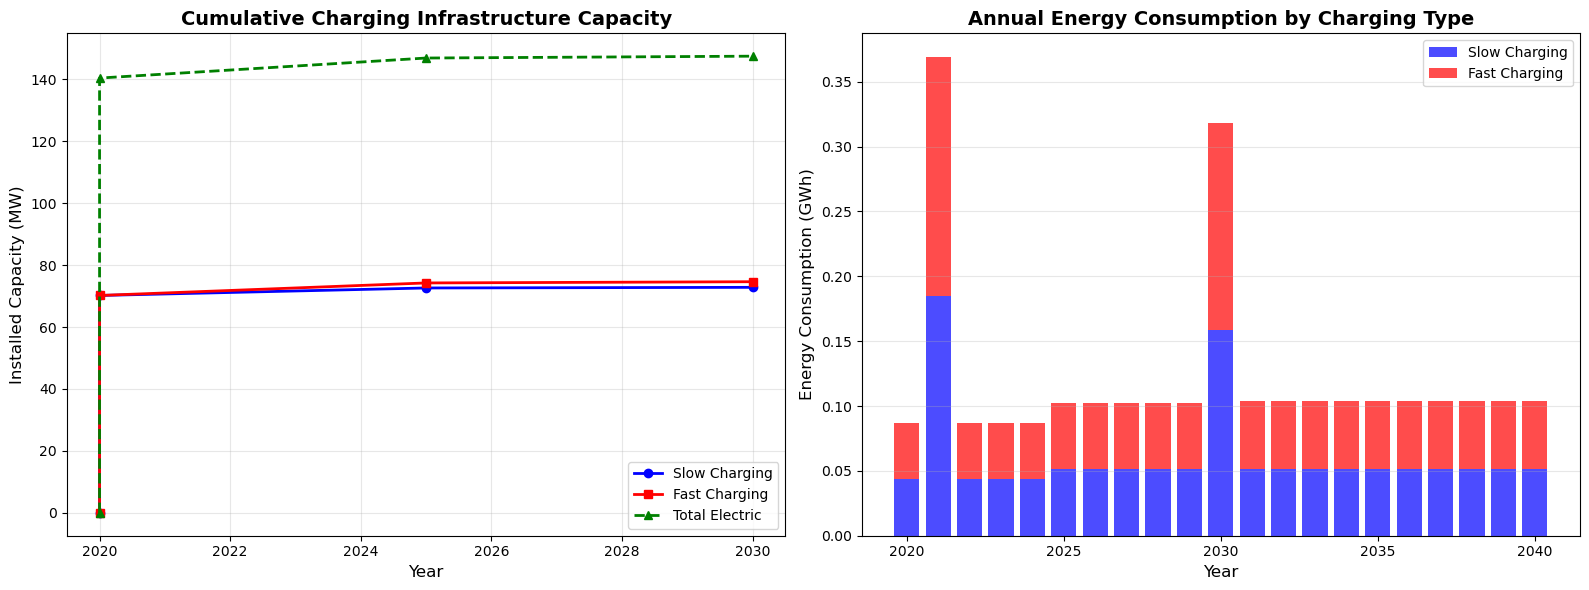


ELECTRIFICATION TIMING BY ROUTE LENGTH

BEV vehicle ID: 1

Electrification Statistics by Route Length:

  300-500 km:
    First electrification: 2020
    Total BEV flow: 9,014 thousand tonnes

  500-1000 km:
    First electrification: 2020
    Total BEV flow: 7,931 thousand tonnes

  >1000 km:
    First electrification: 2020
    Total BEV flow: 1,157 thousand tonnes


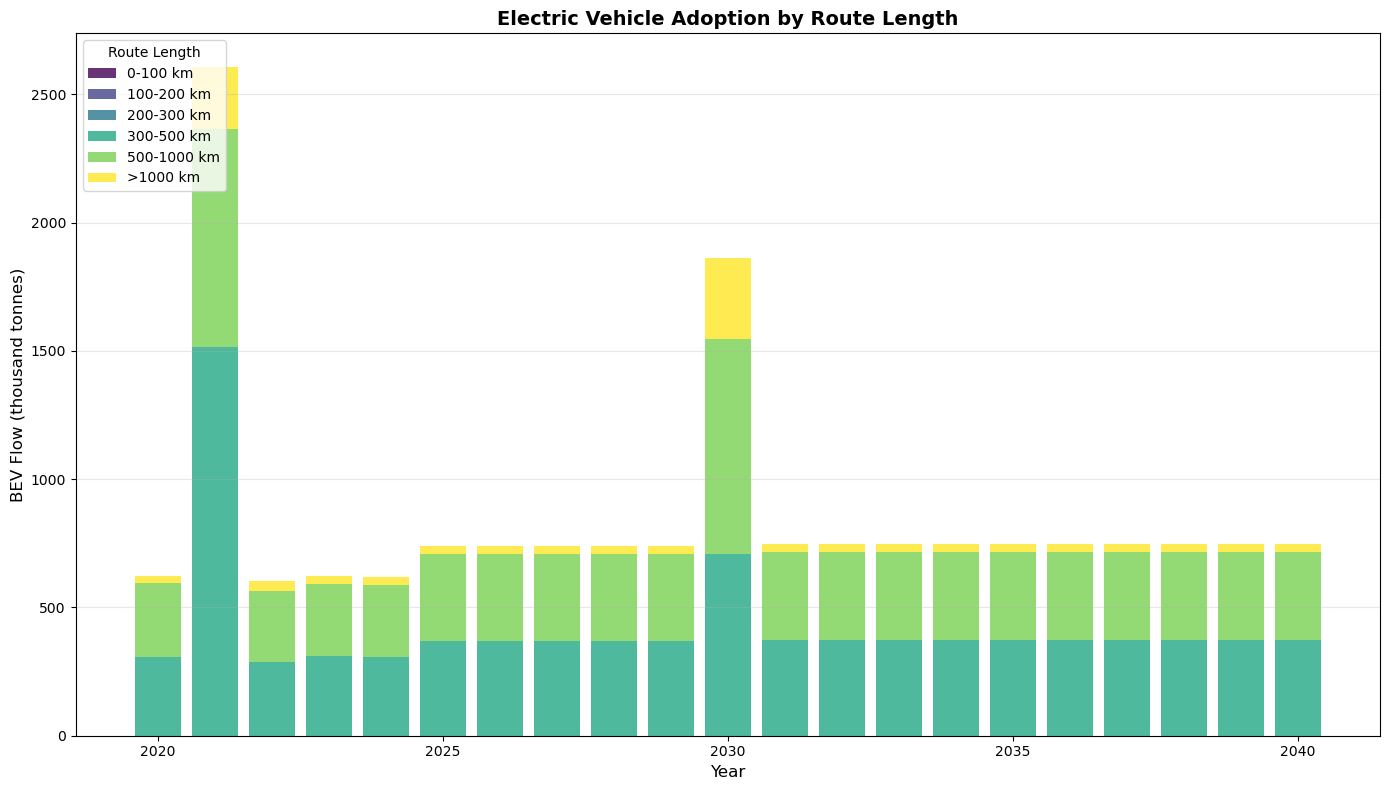

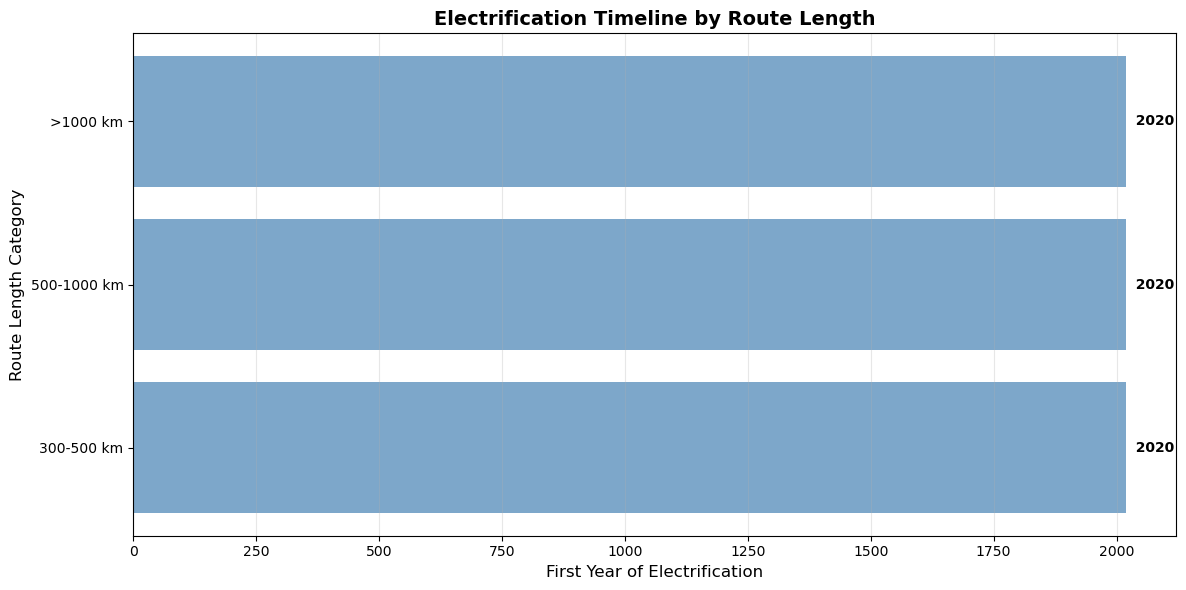


ROUTE-SPECIFIC ELECTRIFICATION ANALYSIS (2035)

Total routes with traffic in 2035: 2928
  Fully electrified (100%): 155 routes
  Partially electrified (0-100%): 0 routes
  Not electrified (0%): 2773 routes
  Average electrification rate: 5.3%

TOP 20 MOST ELECTRIFIED ROUTES IN 2035
 odpair_id  path_id  path_length_km  total_flow  bev_flow  diesel_flow  electrification_rate
        33       33      424.591038    17.63000  17.63000          0.0                 100.0
        62       62      378.580894     1.62250   1.62250          0.0                 100.0
        63       63      400.659976     4.11000   4.11000          0.0                 100.0
        90       90      458.963292    44.77875  44.77875          0.0                 100.0
        91       91      449.986940    20.48250  20.48250          0.0                 100.0
        92       92      482.950401    14.49125  14.49125          0.0                 100.0
        93       93      473.923471    16.33375  16.33375        

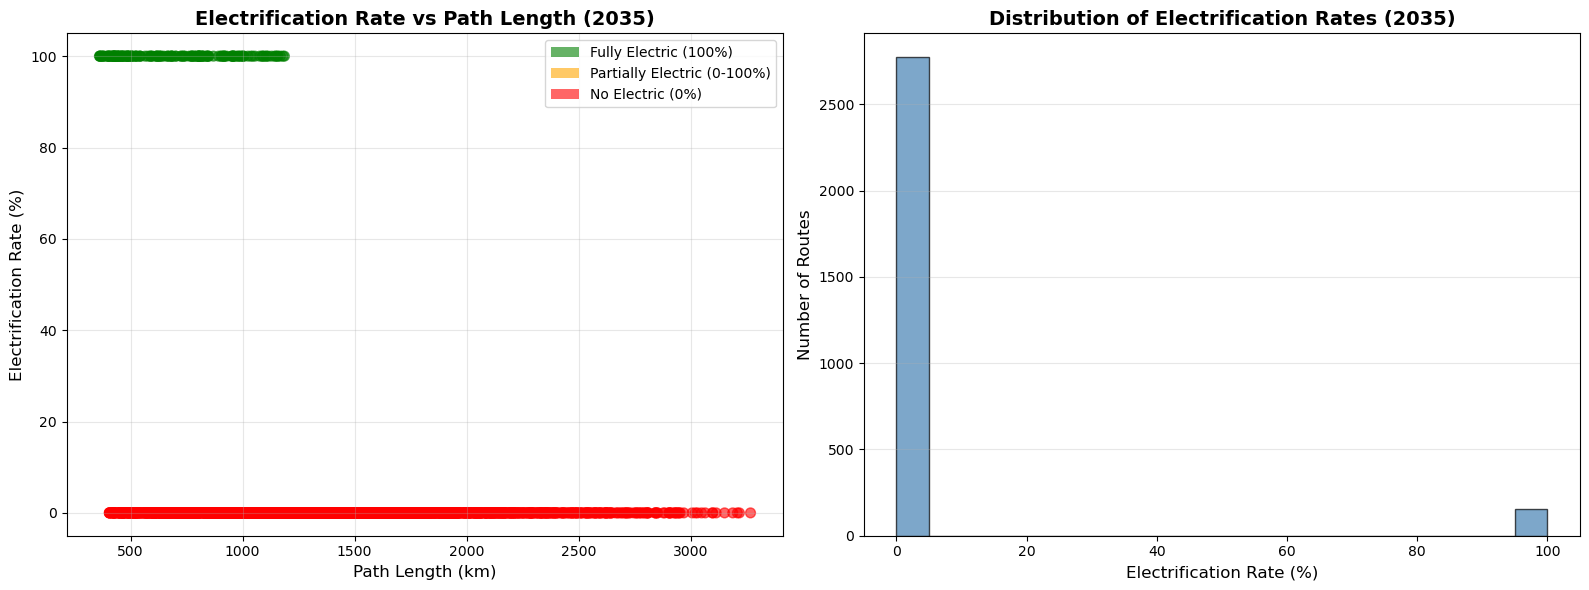


ELECTRIFICATION STATISTICS BY PATH LENGTH CATEGORY
                 Num_Routes  Avg_Electrification_%  Min_%  Max_%  Total_Flow  BEV_Flow
length_category                                                                       
0-100 km                  0                    NaN    NaN    NaN        0.00      0.00
100-200 km                0                    NaN    NaN    NaN        0.00      0.00
200-300 km                0                    NaN    NaN    NaN        0.00      0.00
300-500 km              112                  42.86    0.0  100.0    24921.72    372.71
500-1000 km             723                  11.76    0.0  100.0    21231.69    343.06
>1000 km               2093                   1.05    0.0  100.0     2494.02     31.13


C:\Users\simuser\AppData\Local\Temp\ipykernel_9052\511218667.py:400: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_stats = df_routes.groupby('length_category').agg({
C:\Users\simuser\AppData\Local\Temp\ipykernel_9052\511218667.py:414: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  category_means = df_routes.groupby('length_category')['electrification_rate'].mean()


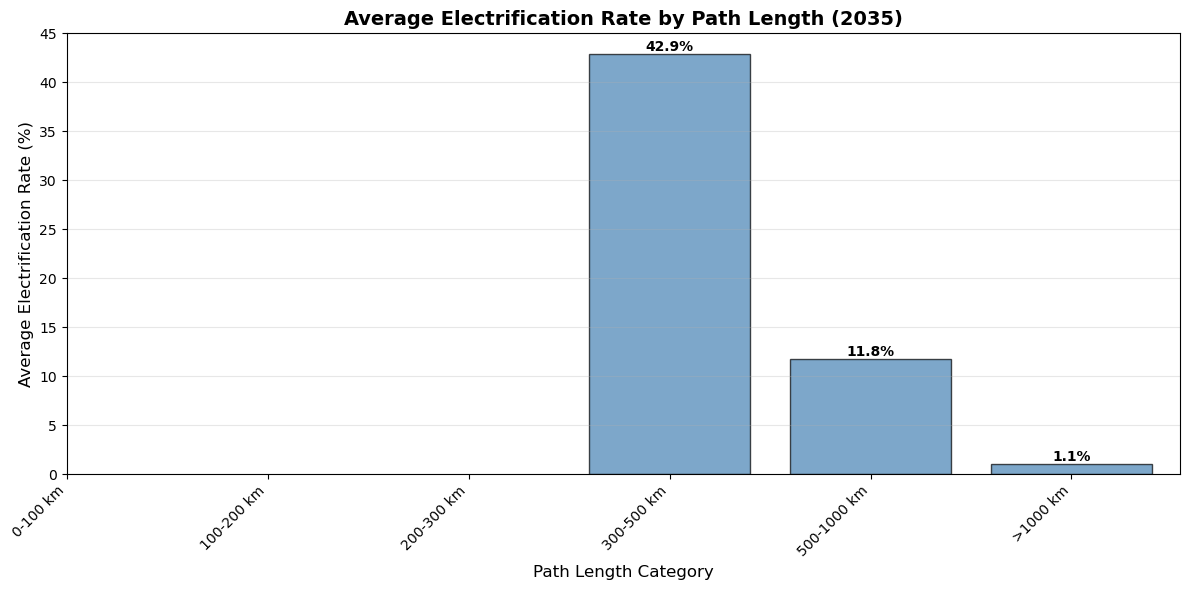


ANALYSIS COMPLETE


In [22]:
# Comprehensive Charging Analysis and Electrification Timing by Route Length

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

print("="*80)
print("CHARGING INFRASTRUCTURE CAPACITY USAGE ANALYSIS")
print("="*80)

# 1. IDENTIFY INFRASTRUCTURE TYPES
slow_charging_id = None
fast_charging_id = None
electricity_fuel_id = fuel_list['electricity']['id']

for infr_id, infr_data in fueling_infr_types_list.items():
    if infr_data['fuel'] == 'electricity':
        if 'slow' in infr_data['fueling_type'].lower():
            slow_charging_id = infr_id
        elif 'fast' in infr_data['fueling_type'].lower():
            fast_charging_id = infr_id

print(f"\nInfrastructure IDs:")
print(f"  Slow charging: {slow_charging_id}")
print(f"  Fast charging: {fast_charging_id}")
print(f"  Electricity fuel ID: {electricity_fuel_id}")

# 2. CALCULATE CAPACITY ADDITIONS BY TYPE AND YEAR
slow_capacity_by_year = {}
fast_capacity_by_year = {}

for key, value in output_data['q_fuel_infr_plus'].items():
    year = key[0]
    f_l = key[1]
    fuel_id = f_l[0]
    infr_id = f_l[1]

    if fuel_id == electricity_fuel_id:
        if infr_id == slow_charging_id:
            slow_capacity_by_year[year] = slow_capacity_by_year.get(year, 0) + value
        elif infr_id == fast_charging_id:
            fast_capacity_by_year[year] = fast_capacity_by_year.get(year, 0) + value

# 3. CALCULATE TOTAL INSTALLED CAPACITY (INITIAL + ADDED)
initial_slow = 0
initial_fast = 0

for key, value in initial_fueling_infr.items():
    fuel_name, infr_id, geo_id = key
    if fuel_name == 'electricity':
        if infr_id == slow_charging_id:
            initial_slow += value['installed_kW']
        elif infr_id == fast_charging_id:
            initial_fast += value['installed_kW']

print(f"\nInitial Capacity (kW):")
print(f"  Slow charging: {initial_slow:,.0f} kW ({initial_slow/1000:.1f} MW)")
print(f"  Fast charging: {initial_fast:,.0f} kW ({initial_fast/1000:.1f} MW)")

# Calculate cumulative additions
years = sorted(set(list(slow_capacity_by_year.keys()) + list(fast_capacity_by_year.keys())))
slow_cumulative = [initial_slow]
fast_cumulative = [initial_fast]

for year in years:
    slow_cumulative.append(slow_cumulative[-1] + slow_capacity_by_year.get(year, 0))
    fast_cumulative.append(fast_cumulative[-1] + fast_capacity_by_year.get(year, 0))

# 4. CALCULATE ENERGY CONSUMPTION BY CHARGING TYPE
slow_energy_by_year = {}
fast_energy_by_year = {}

for key, value in output_data['s'].items():
    year = key[0]
    f_l = key[3]
    fuel_id = f_l[0]
    infr_id = f_l[1]

    if fuel_id == electricity_fuel_id:
        if infr_id == slow_charging_id:
            slow_energy_by_year[year] = slow_energy_by_year.get(year, 0) + value
        elif infr_id == fast_charging_id:
            fast_energy_by_year[year] = fast_energy_by_year.get(year, 0) + value

# 5. PRINT STATISTICS
print(f"\nCapacity Additions (kW):")
print(f"  Slow charging total added: {sum(slow_capacity_by_year.values()):,.0f} kW ({sum(slow_capacity_by_year.values())/1000:.1f} MW)")
print(f"  Fast charging total added: {sum(fast_capacity_by_year.values()):,.0f} kW ({sum(fast_capacity_by_year.values())/1000:.1f} MW)")

print(f"\nFinal Total Capacity ({years[-1] if years else 'N/A'}):")
print(f"  Slow charging: {slow_cumulative[-1]:,.0f} kW ({slow_cumulative[-1]/1000:.1f} MW)")
print(f"  Fast charging: {fast_cumulative[-1]:,.0f} kW ({fast_cumulative[-1]/1000:.1f} MW)")
print(f"  Total electric: {(slow_cumulative[-1] + fast_cumulative[-1]):,.0f} kW ({(slow_cumulative[-1] + fast_cumulative[-1])/1000:.1f} MW)")

print(f"\nEnergy Consumption (kWh):")
print(f"  Slow charging total: {sum(slow_energy_by_year.values()):,.0f} kWh ({sum(slow_energy_by_year.values())/1e6:.2f} GWh)")
print(f"  Fast charging total: {sum(fast_energy_by_year.values()):,.0f} kWh ({sum(fast_energy_by_year.values())/1e6:.2f} GWh)")

# 6. CAPACITY UTILIZATION RATES
print(f"\nCapacity Utilization Analysis:")
if slow_cumulative[-1] > 0:
    slow_util = sum(slow_energy_by_year.values()) / (slow_cumulative[-1] * len(years) * 8760) * 100
    print(f"  Slow charging utilization: {slow_util:.2f}%")
if fast_cumulative[-1] > 0:
    fast_util = sum(fast_energy_by_year.values()) / (fast_cumulative[-1] * len(years) * 8760) * 100
    print(f"  Fast charging utilization: {fast_util:.2f}%")

# 7. PLOT CAPACITY EVOLUTION
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Cumulative capacity
years_plot = [y_init] + list(years)
ax1.plot(years_plot, [x/1000 for x in slow_cumulative], marker='o', linewidth=2, label='Slow Charging', color='blue')
ax1.plot(years_plot, [x/1000 for x in fast_cumulative], marker='s', linewidth=2, label='Fast Charging', color='red')
ax1.plot(years_plot, [(s+f)/1000 for s, f in zip(slow_cumulative, fast_cumulative)],
         marker='^', linewidth=2, label='Total Electric', color='green', linestyle='--')
ax1.set_xlabel('Year', fontsize=12)
ax1.set_ylabel('Installed Capacity (MW)', fontsize=12)
ax1.set_title('Cumulative Charging Infrastructure Capacity', fontsize=14, fontweight='bold')
ax1.legend(fontsize=10)
ax1.grid(alpha=0.3)

# Plot 2: Annual energy consumption
energy_years = sorted(set(list(slow_energy_by_year.keys()) + list(fast_energy_by_year.keys())))
slow_energy_plot = [slow_energy_by_year.get(y, 0)/1e6 for y in energy_years]
fast_energy_plot = [fast_energy_by_year.get(y, 0)/1e6 for y in energy_years]

ax2.bar(energy_years, slow_energy_plot, label='Slow Charging', color='blue', alpha=0.7)
ax2.bar(energy_years, fast_energy_plot, bottom=slow_energy_plot, label='Fast Charging', color='red', alpha=0.7)
ax2.set_xlabel('Year', fontsize=12)
ax2.set_ylabel('Energy Consumption (GWh)', fontsize=12)
ax2.set_title('Annual Energy Consumption by Charging Type', fontsize=14, fontweight='bold')
ax2.legend(fontsize=10)
ax2.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# 8. ELECTRIFICATION TIMING BY ROUTE LENGTH
print("\n" + "="*80)
print("ELECTRIFICATION TIMING BY ROUTE LENGTH")
print("="*80)

# Get BEV vehicle type ID
bev_vehicle_id = None
for v_id, v_data in techvehicle_list.items():
    technology_list_id = v_data['technology']
    technology_data = technology_list[technology_list_id]
    if technology_data['fuel'] == 'electricity':
        bev_vehicle_id = v_id
        print(f"\nBEV vehicle ID: {bev_vehicle_id}")
        break

if bev_vehicle_id is not None:
    # Create route length bins
    route_lengths = {}
    for odpair_id, odpair_data in odpair_list.items():
        path_id = odpair_data['path_id']
        path_data = path_list[path_id]
        length = path_data['length']
        route_lengths[odpair_id] = length

    # Define route length categories
    length_bins = [0, 100, 200, 300, 500, 1000, float('inf')]
    length_labels = ['0-100 km', '100-200 km', '200-300 km', '300-500 km', '500-1000 km', '>1000 km']

    # Analyze electrification by route length and year
    electrification_data = {label: {} for label in length_labels}

    for key, value in output_data['f'].items():
        year = key[0]
        odpair_id = key[1][1]  # Fixed: Extract actual odpair_id (was [0] which always gave 0)
        mode_id = key[2][0]
        vehicle_id = key[2][1]
        gen = key[3]

        if vehicle_id == bev_vehicle_id and value > 0:
            route_length = route_lengths.get(odpair_id, 0)

            # Find appropriate bin
            for i, (low, high) in enumerate(zip(length_bins[:-1], length_bins[1:])):
                if low <= route_length < high:
                    label = length_labels[i]
                    if year not in electrification_data[label]:
                        electrification_data[label][year] = 0
                    electrification_data[label][year] += value
                    break

    # Print statistics
    print(f"\nElectrification Statistics by Route Length:")
    for label in length_labels:
        if electrification_data[label]:
            first_year = min(electrification_data[label].keys())
            total_flow = sum(electrification_data[label].values())
            print(f"\n  {label}:")
            print(f"    First electrification: {first_year}")
            print(f"    Total BEV flow: {total_flow:,.0f} thousand tonnes")

    # Plot electrification timing
    fig, ax = plt.subplots(figsize=(14, 8))

    years_all = sorted(set(year for data in electrification_data.values() for year in data.keys()))

    bottom = np.zeros(len(years_all))
    colors = plt.cm.viridis(np.linspace(0, 1, len(length_labels)))

    for i, label in enumerate(length_labels):
        values = [electrification_data[label].get(year, 0) for year in years_all]
        ax.bar(years_all, values, bottom=bottom, label=label, color=colors[i], alpha=0.8)
        bottom += values

    ax.set_xlabel('Year', fontsize=12)
    ax.set_ylabel('BEV Flow (thousand tonnes)', fontsize=12)
    ax.set_title('Electric Vehicle Adoption by Route Length', fontsize=14, fontweight='bold')
    ax.legend(title='Route Length', fontsize=10, loc='upper left')
    ax.grid(axis='y', alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Additional plot: First year of electrification by route length
    first_years = {}
    for label in length_labels:
        if electrification_data[label]:
            first_years[label] = min(electrification_data[label].keys())

    if first_years:
        fig, ax = plt.subplots(figsize=(12, 6))
        labels_with_data = list(first_years.keys())
        years_first = list(first_years.values())

        bars = ax.barh(labels_with_data, years_first, color='steelblue', alpha=0.7)
        ax.set_xlabel('First Year of Electrification', fontsize=12)
        ax.set_ylabel('Route Length Category', fontsize=12)
        ax.set_title('Electrification Timeline by Route Length', fontsize=14, fontweight='bold')
        ax.grid(axis='x', alpha=0.3)

        # Add year labels on bars
        for bar, year in zip(bars, years_first):
            width = bar.get_width()
            ax.text(width, bar.get_y() + bar.get_height()/2, f'  {int(year)}',
                   va='center', fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.show()
else:
    print("\nNo BEV vehicle type found in the data.")


# 9. ROUTE-SPECIFIC ELECTRIFICATION ANALYSIS FOR 2035
print("\n" + "="*80)
print("ROUTE-SPECIFIC ELECTRIFICATION ANALYSIS (2035)")
print("="*80)

target_year = 2035

if bev_vehicle_id is not None:
    # Calculate total flow and BEV flow by route for 2035
    route_data = {}

    for odpair_id, odpair_data in odpair_list.items():
        path_id = odpair_data['path_id']
        path_length = path_list[path_id]['length']

        # Initialize route data
        if odpair_id not in route_data:
            route_data[odpair_id] = {
                'path_id': path_id,
                'path_length': path_length,
                'total_flow': 0,
                'bev_flow': 0,
                'diesel_flow': 0
            }

        # Sum flows for this route in 2035
        for key, value in output_data['f'].items():
            year = key[0]
            od_id = key[1][1]  # Extract actual odpair_id from tuple
            vehicle_id = key[2][1]  # Extract vehicle_id from mode-vehicle tuple

            if year == target_year and od_id == odpair_id and value > 0:
                route_data[odpair_id]['total_flow'] += value
                if vehicle_id == bev_vehicle_id:
                    route_data[odpair_id]['bev_flow'] += value
                else:
                    route_data[odpair_id]['diesel_flow'] += value

    # Calculate electrification rates
    route_analysis = []
    for odpair_id, data in route_data.items():
        if data['total_flow'] > 0:
            electrification_rate = (data['bev_flow'] / data['total_flow']) * 100
            route_analysis.append({
                'odpair_id': odpair_id,
                'path_id': data['path_id'],
                'path_length_km': data['path_length'],
                'total_flow': data['total_flow'],
                'bev_flow': data['bev_flow'],
                'diesel_flow': data['diesel_flow'],
                'electrification_rate': electrification_rate
            })

    # Sort by electrification rate (descending)
    route_analysis_sorted = sorted(route_analysis, key=lambda x: x['electrification_rate'], reverse=True)

    # Print summary statistics
    print(f"\nTotal routes with traffic in {target_year}: {len(route_analysis)}")
    fully_electric = sum(1 for r in route_analysis if r['electrification_rate'] == 100)
    partially_electric = sum(1 for r in route_analysis if 0 < r['electrification_rate'] < 100)
    no_electric = sum(1 for r in route_analysis if r['electrification_rate'] == 0)

    print(f"  Fully electrified (100%): {fully_electric} routes")
    print(f"  Partially electrified (0-100%): {partially_electric} routes")
    print(f"  Not electrified (0%): {no_electric} routes")

    if len(route_analysis) > 0:
        avg_electrification = sum(r['electrification_rate'] for r in route_analysis) / len(route_analysis)
        print(f"  Average electrification rate: {avg_electrification:.1f}%")

    # Create DataFrame for better display
    import pandas as pd
    
    # Handle empty case
    if len(route_analysis_sorted) > 0:
        df_routes = pd.DataFrame(route_analysis_sorted)
    else:
        df_routes = pd.DataFrame(columns=[
            'odpair_id', 'path_id', 'path_length_km', 'total_flow',
            'bev_flow', 'diesel_flow', 'electrification_rate'
        ])
        print("WARNING: No routes with traffic found in target year!")

    print(f"\n{'='*80}")
    print("TOP 20 MOST ELECTRIFIED ROUTES IN 2035")
    print(f"{"="*80}")
    if len(df_routes) > 0:
        print(df_routes.head(20).to_string(index=False))
    else:
        print("No data available")

    print(f"{'='*80}")
    print("ROUTES WITH NO ELECTRIFICATION (showing first 20)")
    print(f"{'='*80}")
    if len(df_routes) > 0:
        zero_electric = df_routes[df_routes['electrification_rate'] == 0].head(20)
        if len(zero_electric) > 0:
            print(zero_electric.to_string(index=False))
        else:
            print("No routes with zero electrification!")
    else:
        print("No data available")

    if len(df_routes) > 0:
        # Plot: Electrification rate vs path length
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Scatter plot: electrification rate vs path length
        colors = ['green' if r == 100 else 'orange' if r > 0 else 'red'
                  for r in df_routes['electrification_rate']]
        scatter = ax1.scatter(df_routes['path_length_km'], df_routes['electrification_rate'],
                             c=colors, alpha=0.6, s=50)
        ax1.set_xlabel('Path Length (km)', fontsize=12)
        ax1.set_ylabel('Electrification Rate (%)', fontsize=12)
        ax1.set_title(f'Electrification Rate vs Path Length ({target_year})', fontsize=14, fontweight='bold')
        ax1.grid(alpha=0.3)
        ax1.set_ylim(-5, 105)

        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='green', alpha=0.6, label='Fully Electric (100%)'),
            Patch(facecolor='orange', alpha=0.6, label='Partially Electric (0-100%)'),
            Patch(facecolor='red', alpha=0.6, label='No Electric (0%)')
        ]
        ax1.legend(handles=legend_elements, loc='best')

        # Histogram: Distribution of electrification rates
        ax2.hist(df_routes['electrification_rate'], bins=20, color='steelblue', alpha=0.7, edgecolor='black')
        ax2.set_xlabel('Electrification Rate (%)', fontsize=12)
        ax2.set_ylabel('Number of Routes', fontsize=12)
        ax2.set_title(f'Distribution of Electrification Rates ({target_year})', fontsize=14, fontweight='bold')
        ax2.grid(axis='y', alpha=0.3)

        plt.tight_layout()
        plt.show()

        # Additional analysis: Electrification by path length category
        print(f"\n{'='*80}")
        print("ELECTRIFICATION STATISTICS BY PATH LENGTH CATEGORY")
        print(f"{'='*80}")

        length_bins = [0, 100, 200, 300, 500, 1000, float('inf')]
        length_labels = ['0-100 km', '100-200 km', '200-300 km', '300-500 km', '500-1000 km', '>1000 km']

        df_routes['length_category'] = pd.cut(df_routes['path_length_km'],
                                               bins=length_bins,
                                               labels=length_labels,
                                               include_lowest=True)

        category_stats = df_routes.groupby('length_category').agg({
            'odpair_id': 'count',
            'electrification_rate': ['mean', 'min', 'max'],
            'total_flow': 'sum',
            'bev_flow': 'sum'
        }).round(2)

        category_stats.columns = ['Num_Routes', 'Avg_Electrification_%', 'Min_%', 'Max_%', 'Total_Flow', 'BEV_Flow']

        print(category_stats.to_string())

        # Plot by category
        fig, ax = plt.subplots(figsize=(12, 6))

        category_means = df_routes.groupby('length_category')['electrification_rate'].mean()
        bars = ax.bar(range(len(category_means)), category_means, color='steelblue', alpha=0.7, edgecolor='black')
        ax.set_xticks(range(len(category_means)))
        ax.set_xticklabels(category_means.index, rotation=45, ha='right')
        ax.set_xlabel('Path Length Category', fontsize=12)
        ax.set_ylabel('Average Electrification Rate (%)', fontsize=12)
        ax.set_title(f'Average Electrification Rate by Path Length ({target_year})', fontsize=14, fontweight='bold')
        ax.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                    f'{height:.1f}%',
                    ha='center', va='bottom', fontsize=10, fontweight='bold')

        plt.tight_layout()
        plt.show()

    else:
        print("No data available for visualizations")

else:
    print("\nCannot perform route analysis: BEV vehicle type not identified")

print("\n" + "="*80)
print("ANALYSIS COMPLETE")
print("="*80)


In [23]:

# Create DataFrame for better display
import pandas as pd

# Define columns explicitly to handle empty case
if len(route_analysis_sorted) > 0:
    df_routes = pd.DataFrame(route_analysis_sorted)
else:
    # Create empty DataFrame with expected columns
    df_routes = pd.DataFrame(columns=[
        'odpair_id', 'path_id', 'path_length_km', 'total_flow',
        'bev_flow', 'diesel_flow', 'electrification_rate'
    ])
    print("\nWARNING: No routes with traffic found in the data!")

# Now the rest of the code will work whether df_routes is empty or not
print(f"\n{'='*80}")
print("TOP 20 MOST ELECTRIFIED ROUTES IN 2035")
print(f"{'='*80}")
if len(df_routes) > 0:
    print(df_routes.head(20).to_string(index=False))
else:
    print("No data available")

print(f"\n{'='*80}")
print("ROUTES WITH NO ELECTRIFICATION (showing first 20)")
print(f"{'='*80}")
if len(df_routes) > 0:
    zero_electric = df_routes[df_routes['electrification_rate'] == 0].head(20)
    if len(zero_electric) > 0:
        print(zero_electric.to_string(index=False))
    else:
        print("No routes with 0% electrification")
else:
    print("No data available")


TOP 20 MOST ELECTRIFIED ROUTES IN 2035
 odpair_id  path_id  path_length_km  total_flow  bev_flow  diesel_flow  electrification_rate
        33       33      424.591038    17.63000  17.63000          0.0                 100.0
        62       62      378.580894     1.62250   1.62250          0.0                 100.0
        63       63      400.659976     4.11000   4.11000          0.0                 100.0
        90       90      458.963292    44.77875  44.77875          0.0                 100.0
        91       91      449.986940    20.48250  20.48250          0.0                 100.0
        92       92      482.950401    14.49125  14.49125          0.0                 100.0
        93       93      473.923471    16.33375  16.33375          0.0                 100.0
       114      114      589.000000     0.32375   0.32375          0.0                 100.0
       120      120      521.619220    15.51750  15.51750          0.0                 100.0
       142      142      364.0

## Mandatory Breaks Validation

Validate and visualize mandatory breaks from the input data according to EU Regulation (EC) No 561/2006.

Loaded 9560 mandatory breaks from 2928 paths

MANDATORY BREAKS SUMMARY

Total paths with breaks: 2928
Total mandatory breaks: 9560
  - Type B (short breaks): 7381
  - Type R (rest periods): 2179

Charging type distribution:
  - Fast charging: 7381
  - Slow charging: 2179

Path characteristics:
  Average path length: 1352.3 km
  Average driving time: 16.90 h
  Average breaks per path: 3.3

BREAK TIMING VALIDATION

⚠️ Found 166 breaks with timing issues:
 path_id  path_length  total_time  break_number  time_since_last  expected  deviation
      33   424.591038    5.307388             1         3.122687       4.5   1.377313
      62   378.580894    4.732261             1         1.722624       4.5   2.777376
      63   400.659976    5.008250             1         1.862494       4.5   2.637506
      90   458.963292    5.737041             1         1.977386       4.5   2.522614
      91   449.986940    5.624837             1         2.296260       4.5   2.203740
      92   482.950401    6.

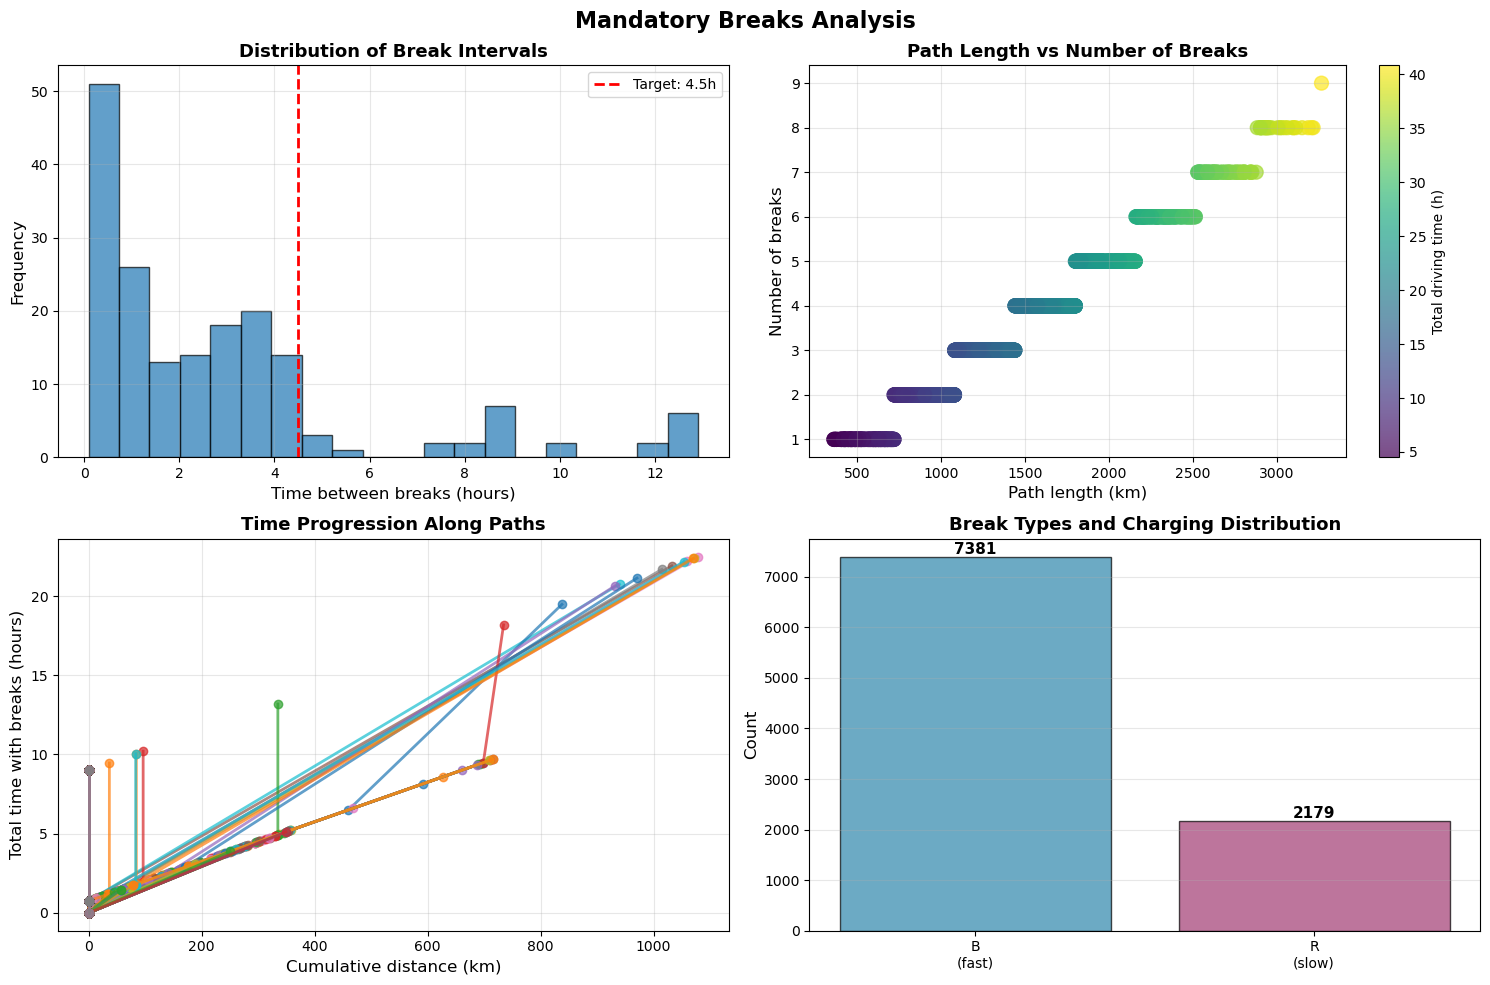


VALIDATION COMPLETE


In [24]:
"""
Mandatory Breaks Validation and Visualization

This section validates and visualizes the mandatory breaks from the input data.
It checks:
1. Total travel time for each path
2. Break intervals (should be ~4.5h of driving between breaks)
3. Break durations (45min for breaks, 9h for rests)
4. Distance and time progression along paths
"""

import yaml
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Configuration
SHORT_BREAK_INTERVAL = 4.5  # hours
SHORT_BREAK_DURATION = 0.75  # hours (45 minutes)
DAILY_REST_DURATION = 9.0  # hours

# Load mandatory breaks from input data
breaks = input_data["MandatoryBreaks"]
df_breaks = pd.DataFrame(breaks)

print(f"Loaded {len(df_breaks)} mandatory breaks from {df_breaks['path_id'].nunique()} paths")

# Summary statistics
print("\n" + "="*80)
print("MANDATORY BREAKS SUMMARY")
print("="*80)

print(f"\nTotal paths with breaks: {df_breaks['path_id'].nunique()}")
print(f"Total mandatory breaks: {len(df_breaks)}")
print(f"  - Type B (short breaks): {len(df_breaks[df_breaks['event_type'] == 'B'])}")
print(f"  - Type R (rest periods): {len(df_breaks[df_breaks['event_type'] == 'R'])}")

print(f"\nCharging type distribution:")
print(f"  - Fast charging: {len(df_breaks[df_breaks['charging_type'] == 'fast'])}")
print(f"  - Slow charging: {len(df_breaks[df_breaks['charging_type'] == 'slow'])}")

# Path characteristics
path_summary = df_breaks.groupby('path_id').agg({
    'path_length': 'first',
    'total_driving_time': 'first',
    'num_drivers': 'first',
    'break_number': 'max'
}).reset_index()

print(f"\nPath characteristics:")
print(f"  Average path length: {path_summary['path_length'].mean():.1f} km")
print(f"  Average driving time: {path_summary['total_driving_time'].mean():.2f} h")
print(f"  Average breaks per path: {path_summary['break_number'].mean():.1f}")

# Validate break timing
print("\n" + "="*80)
print("BREAK TIMING VALIDATION")
print("="*80)

timing_issues = []
for path_id, path_breaks in df_breaks.groupby('path_id'):
    path_breaks = path_breaks.sort_values('break_number')

    prev_driving_time = 0.0
    for idx, row in path_breaks.iterrows():
        time_since_last = row['cumulative_driving_time'] - prev_driving_time

        # Check if timing is correct (within 10% tolerance or first break)
        timing_ok = abs(time_since_last - SHORT_BREAK_INTERVAL) < 0.5 or time_since_last == 0.0

        if not timing_ok:
            timing_issues.append({
                'path_id': path_id,
                'path_length': row['path_length'],
                'total_time': row['total_driving_time'],
                'break_number': row['break_number'],
                'time_since_last': time_since_last,
                'expected': SHORT_BREAK_INTERVAL,
                'deviation': abs(time_since_last - SHORT_BREAK_INTERVAL)
            })

        prev_driving_time = row['cumulative_driving_time']

if timing_issues:
    print(f"\n⚠️ Found {len(timing_issues)} breaks with timing issues:")
    df_issues = pd.DataFrame(timing_issues)
    print(df_issues.to_string(index=False))
else:
    print("\n✓ All breaks have correct timing!")

# Create visualizations
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('Mandatory Breaks Analysis', fontsize=16, fontweight='bold')

# 1. Break intervals distribution
ax = axes[0, 0]
intervals = []
for path_id, path_breaks in df_breaks.groupby('path_id'):
    path_breaks = path_breaks.sort_values('break_number')
    prev_time = 0.0
    for _, row in path_breaks.iterrows():
        interval = row['cumulative_driving_time'] - prev_time
        if interval > 0:
            intervals.append(interval)
        prev_time = row['cumulative_driving_time']

if intervals:
    ax.hist(intervals, bins=20, edgecolor='black', alpha=0.7)
    ax.axvline(SHORT_BREAK_INTERVAL, color='red', linestyle='--', linewidth=2,
               label=f'Target: {SHORT_BREAK_INTERVAL}h')
ax.set_xlabel('Time between breaks (hours)', fontsize=12)
ax.set_ylabel('Frequency', fontsize=12)
ax.set_title('Distribution of Break Intervals', fontsize=13, fontweight='bold')
ax.legend()
ax.grid(True, alpha=0.3)

# 2. Path length vs number of breaks
ax = axes[0, 1]
scatter = ax.scatter(path_summary['path_length'], path_summary['break_number'],
                     c=path_summary['total_driving_time'], cmap='viridis', s=100, alpha=0.7)
ax.set_xlabel('Path length (km)', fontsize=12)
ax.set_ylabel('Number of breaks', fontsize=12)
ax.set_title('Path Length vs Number of Breaks', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3)
cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Total driving time (h)', fontsize=10)

# 3. Cumulative time progression
ax = axes[1, 0]
for path_id, path_breaks in df_breaks.groupby('path_id'):
    path_breaks = path_breaks.sort_values('break_number')
    plot_x = [0] + list(path_breaks['cumulative_distance'])
    plot_y = [0] + list(path_breaks['time_with_breaks'])
    ax.plot(plot_x, plot_y, marker='o', linewidth=2, markersize=6,
            label=f"Path {path_id} ({path_breaks.iloc[0]['path_length']:.0f} km)", alpha=0.7)

ax.set_xlabel('Cumulative distance (km)', fontsize=12)
ax.set_ylabel('Total time with breaks (hours)', fontsize=12)
ax.set_title('Time Progression Along Paths', fontsize=13, fontweight='bold')
# ax.legend(fontsize=8, loc='upper left')  # Removed: legend obscures plot with many path IDs
ax.grid(True, alpha=0.3)

# 4. Break type distribution
ax = axes[1, 1]
event_counts = df_breaks.groupby(['event_type', 'charging_type']).size().reset_index(name='count')
x_pos = np.arange(len(event_counts))
colors = ['#2E86AB' if ct == 'fast' else '#A23B72' for ct in event_counts['charging_type']]
bars = ax.bar(x_pos, event_counts['count'], color=colors, alpha=0.7, edgecolor='black')
ax.set_xticks(x_pos)
ax.set_xticklabels([f"{row['event_type']}\n({row['charging_type']})"
                     for _, row in event_counts.iterrows()], fontsize=10)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Break Types and Charging Distribution', fontsize=13, fontweight='bold')
ax.grid(True, alpha=0.3, axis='y')

for bar in bars:
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height,
            f'{int(height)}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("VALIDATION COMPLETE")
print("="*80)